<a href="https://colab.research.google.com/github/DPersoon/DeepLearning/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the .zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/Data for Quantification of Shortwave Surface Albedo Feedback using a Neural Network Approach.zip'

# Path to the directory where you want to unzip the files
unzip_dir = '/content/data/'

# Create the directory if it doesn't exist
os.makedirs(unzip_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Now you can set the path for the saved model
path_saved_model = os.path.join(unzip_dir, 'nn_saved_model')  # adjust if needed based on the folder structure

print(f"Model will be saved to: {path_saved_model}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model will be saved to: /content/data/nn_saved_model


In [2]:
import glob
import xarray as xr
import re

def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def read_netcdfs(files, dim):
    '''
    Function to combine several files that have the same
    variables into one single xarray.Dataset

    files: all the files to combine
    dim: the dimension used to combine the files
    returns: xarray.Dataset
    '''

    paths = sorted(glob.glob(files), key=alphanum_key)
    datasets = [xr.open_dataset(p) for p in paths]
    combined = xr.concat(datasets, dim)

    return combined

def build_nn_eq(nds_num,inpt_num,inpt_list,act_func,model):
    '''
    Function to build the NN equation from the weight and
    biases outputs
    '''

    # temporal list as a container for each layer formulas
    formula_list = []
    frml_eqn = []
    y_str = []

    for ii in np.arange(len(model.layers)):
        # get ith Keras layer's weights and biases
        layer = model.layers[ii]
        WB = layer.get_weights()

        #WB[0].shape = (2,2)
        # empty text string to which concatenate current layer formula parts
        formula = ''
        if ii==0:

            for jj in np.arange(nds_num):
                weights = []
                all_terms = []

                for kk in np.arange(inpt_num):
                    cur_weight = WB[0][kk][jj]
                    cur_bias = WB[1][jj]
                    weights.append(cur_weight)
                    # build formula for this layer
                    term = (str(np.round(weights[kk],2))+'*'+inpt_list[kk]+'+' )
                    all_terms.append(term)

                bias = str(np.round(cur_bias,2))
                all_terms.append(bias)

                formula_list.append(all_terms)



        elif ii == (len(model.layers)-1):
            for ll in np.arange(nds_num):
                act_term = ''
                for item in formula_list[ll]:
                    act_term += str(item)
                y_str.append( str(np.round(WB[0][ll],2).squeeze()) + '*(np.'+ act_func+ '(' + act_term +'))+' )

            y_str.append(str(np.round(WB[1][0],2).squeeze()) )

    equation = ''
    for item in y_str:
        equation += str(item)

    # make some cleanings
    equation = equation.replace('+-','-')
    equation = equation.replace('+*0.0*','')
    equation = equation.replace('-*0.0*','')
    str_equation = equation.replace('*','')
    str_equation = str_equation.replace('np.','')

    # saving nn equation in txt file
    file_txt = "eq.txt"
    # Open the file in write mode
    file = open(file_txt, "w")
    # Write the string to the file
    file.write(str_equation)
    # Close the file
    file.close()

    return equation

## min max noralization
def MinMaxNorm(x,a,b):
    ''' Min-max normalization method between a specified range
        Normalization range = [a,b]
        x = input data
        a = lower range
        b = upper range
        This method normalizes the input and output variables for the training of the NN'''

    n = (b-a)*(x-np.min(x))/(np.max(x)-np.min(x))+a
    return n

def MinMaxInverse(n,a,b,df_tsr):
    ''' Min-max inverse transform method
        n = normalized data between [a,b]
        a = lower range
        b = upper range

        This method transforms the range of the predicted values using the NN,
        from -1 to 1 to the correct range of the magnitude of the fnt of sw at TOA'''

    #we define the min and max values from the training dataset
    max_val = np.round(np.max(df_tsr),2)
    min_val = np.round(np.min(df_tsr),2)

    x = (n-a)*(max_val-min_val)/(b-a)+min_val
    return x

#####  Function to train the NN (Heuristic case)
def runNN_h(x_values,y_real,alpha, iterations,shape_input,nodesLayer1, nodesLayer2, act_function1, act_function2, patienceEpochs ,dpii=80):

    start_time = time.time()

    # defining the tensors for the NN
    x=tf.constant(x_values) #albedo
    y=tf.constant(y_real) # prtrbd.fnt_sw_toa.to_numpy()

    # define the model
    model = tf.keras.Sequential(name='Sequential_NN')

    if nodesLayer2 == 0:
        layer1 = Dense(nodesLayer1,activation=act_function1 ,input_shape=[shape_input], name='hiddenLayer1') #11 relu
        output = Dense(1, name='output')

        model.add(layer1)
        model.add(output)

    else:
        layer1 = Dense(nodesLayer1,activation=act_function1 ,input_shape=[shape_input], name='hiddenLayer1') #11 relu
        layer2 = Dense(nodesLayer2,activation=act_function2, name='hiddenLayer2')
        output = Dense(1, name='output')

        model.add(layer1)
        model.add(layer2)
        model.add(output)

    # compile the model
    model.compile(loss='mse',
                  optimizer= tf.keras.optimizers.Adam(learning_rate=alpha),
                  metrics=['accuracy'])

    # display the model
    model.summary()
    ann_viz(model, filename='figure_NN', title="Neural network")

    # save hyperparameters
    weights_dict = {}

    weight_callback = tf.keras.callbacks.LambdaCallback \
    ( on_epoch_end=lambda epoch, logs: weights_dict.update({epoch:model.get_weights()}))

    #adding a callback to stop training
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=patienceEpochs)
 # fit the model
    history = model.fit( x, y, epochs=iterations, callbacks=[weight_callback,es ],verbose=True)
    #print(history.history)

    # get the learning rate value of the model
    lr= K.eval(model.optimizer.lr)

    # plot cost function
    plt.figure(figsize=(8,6),dpi=dpii)
    history_df = pd.DataFrame(history.history)

    plt.plot(history_df['loss'], label='cost')
    plt.yscale('log')

    plt.title('Training cost function with learning rate = '+ str(lr))
    plt.legend()
    plt.show()

    print("--- %s seconds ---" % (time.time() - start_time))

    return(model,history_df,weights_dict)

#####  Function to train the NN (Global case)
def runNN(x_values,y_real,alpha, iterations,shape_input,nodesLayer1, nodesLayer2, act_function1, act_function2,
          earlyStopping, patienceEpochs, loss_thr ,dpii=300):

    start_time = time.time()

    # defining the tensors for the NN
    x=tf.constant(x_values) #albedo
    y=tf.constant(y_real) # prtrbd.fnt_sw_toa.to_numpy()

    # define the model
    model = tf.keras.Sequential(name='Sequential_NN')

    if nodesLayer2 == 0:
        layer1 = Dense(nodesLayer1,activation=act_function1 ,input_shape=[shape_input], name='hiddenLayer1') #11 relu
        output = Dense(1, name='output')

        model.add(layer1)
        model.add(output)

    else:
        layer1 = Dense(nodesLayer1,activation=act_function1 ,input_shape=[shape_input], name='hiddenLayer1') #11 relu
        layer2 = Dense(nodesLayer2,activation=act_function2, name='hiddenLayer2')
        output = Dense(1, name='output')

        model.add(layer1)
        model.add(layer2)
        model.add(output)

    # compile the model
    model.compile(loss='mse',
                  optimizer= tf.keras.optimizers.Adam(learning_rate=alpha),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()]) #'accuracy'

    # display the model
    model.summary()
    ann_viz(model, filename='figure_NN', title="Neural network")

    # save hyperparameters
    weights_dict = {}

    weight_callback = tf.keras.callbacks.LambdaCallback \
    ( on_epoch_end=lambda epoch, logs: weights_dict.update({epoch:model.get_weights()}))

    if earlyStopping==0:
        # fit the model
        history = model.fit( x, y, epochs=iterations, callbacks=[weight_callback],verbose=True)

    if earlyStopping== 1:
        #adding a callback to stop training
        #es = EarlyStoppingByLossVal(monitor='loss', value=loss_thr, verbose=True)
        es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, mode='min',
                                             patience=patienceEpochs)#min_delta=0.00001, start_from_epoch=10)
        # NEED TO CHECK THIS
        #es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, mode='min',
                                              #baseline=loss_thr, min_delta=0.000001, patience=patienceEpochs)#min_delta=0.00001, start_from_epoch=10)

        # fit the model
        history = model.fit( x, y, epochs=iterations, callbacks=[weight_callback,es],verbose=2)
        #print(history.history)

    # get the learning rate value of the model
    lr= K.eval(model.optimizer.lr)

    # plot cost function
    plt.figure(figsize=(8,6),dpi=dpii)
    history_df = pd.DataFrame(history.history)
    plt.plot(history_df['loss'], label='cost')
    plt.yscale('log')
    plt.title('Training cost function with learning rate = '+ str(lr))
    plt.legend()
    plt.savefig('costFunction.png')

    print("--- %s seconds ---" % (time.time() - start_time))

    return(model,history_df,weights_dict)

In [5]:
!pip install tensorflow==2.12.0
!pip install basemap

  Using cached basemap-1.4.1-cp311-cp311-manylinux1_x86_64.whl.metadata (9.1 kB)
  Using cached basemap_data-1.3.2-py2.py3-none-any.whl.metadata (2.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.4/942.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 114.6 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.1
    Uninstalling pyproj-3.7.1:
      Successfully uninstalled pyproj-3.7.1
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successful

61088/61088 [==============================] - 72s 1ms/step


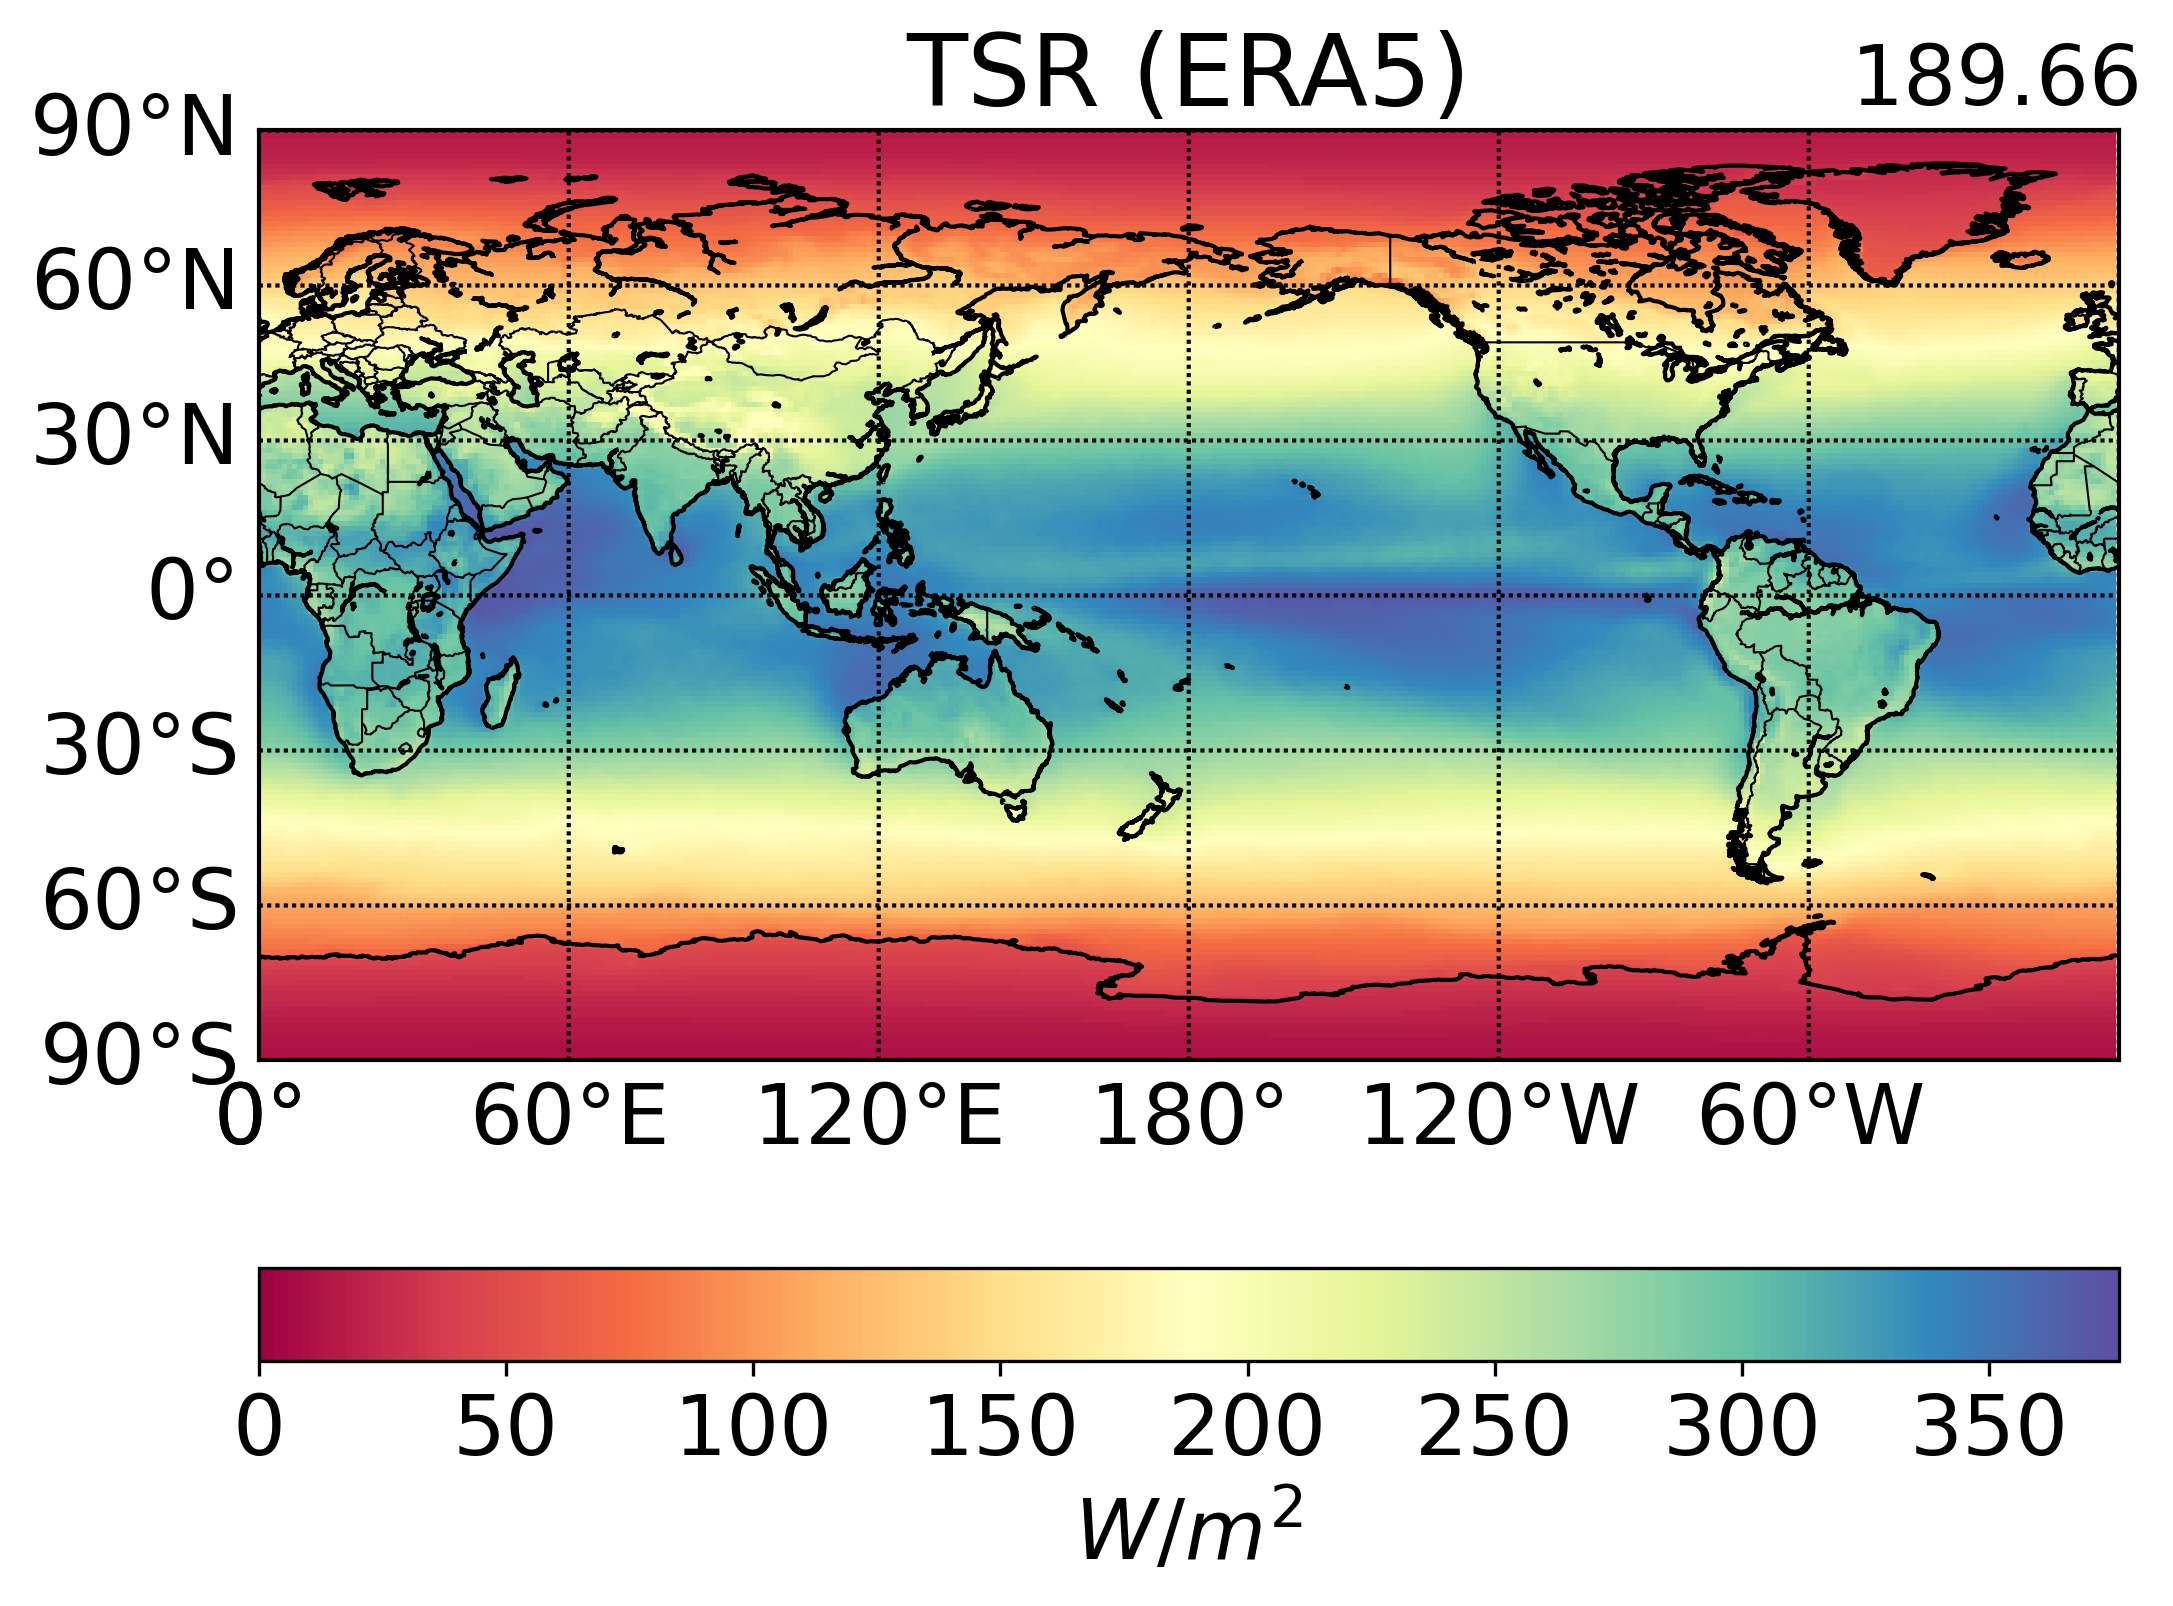

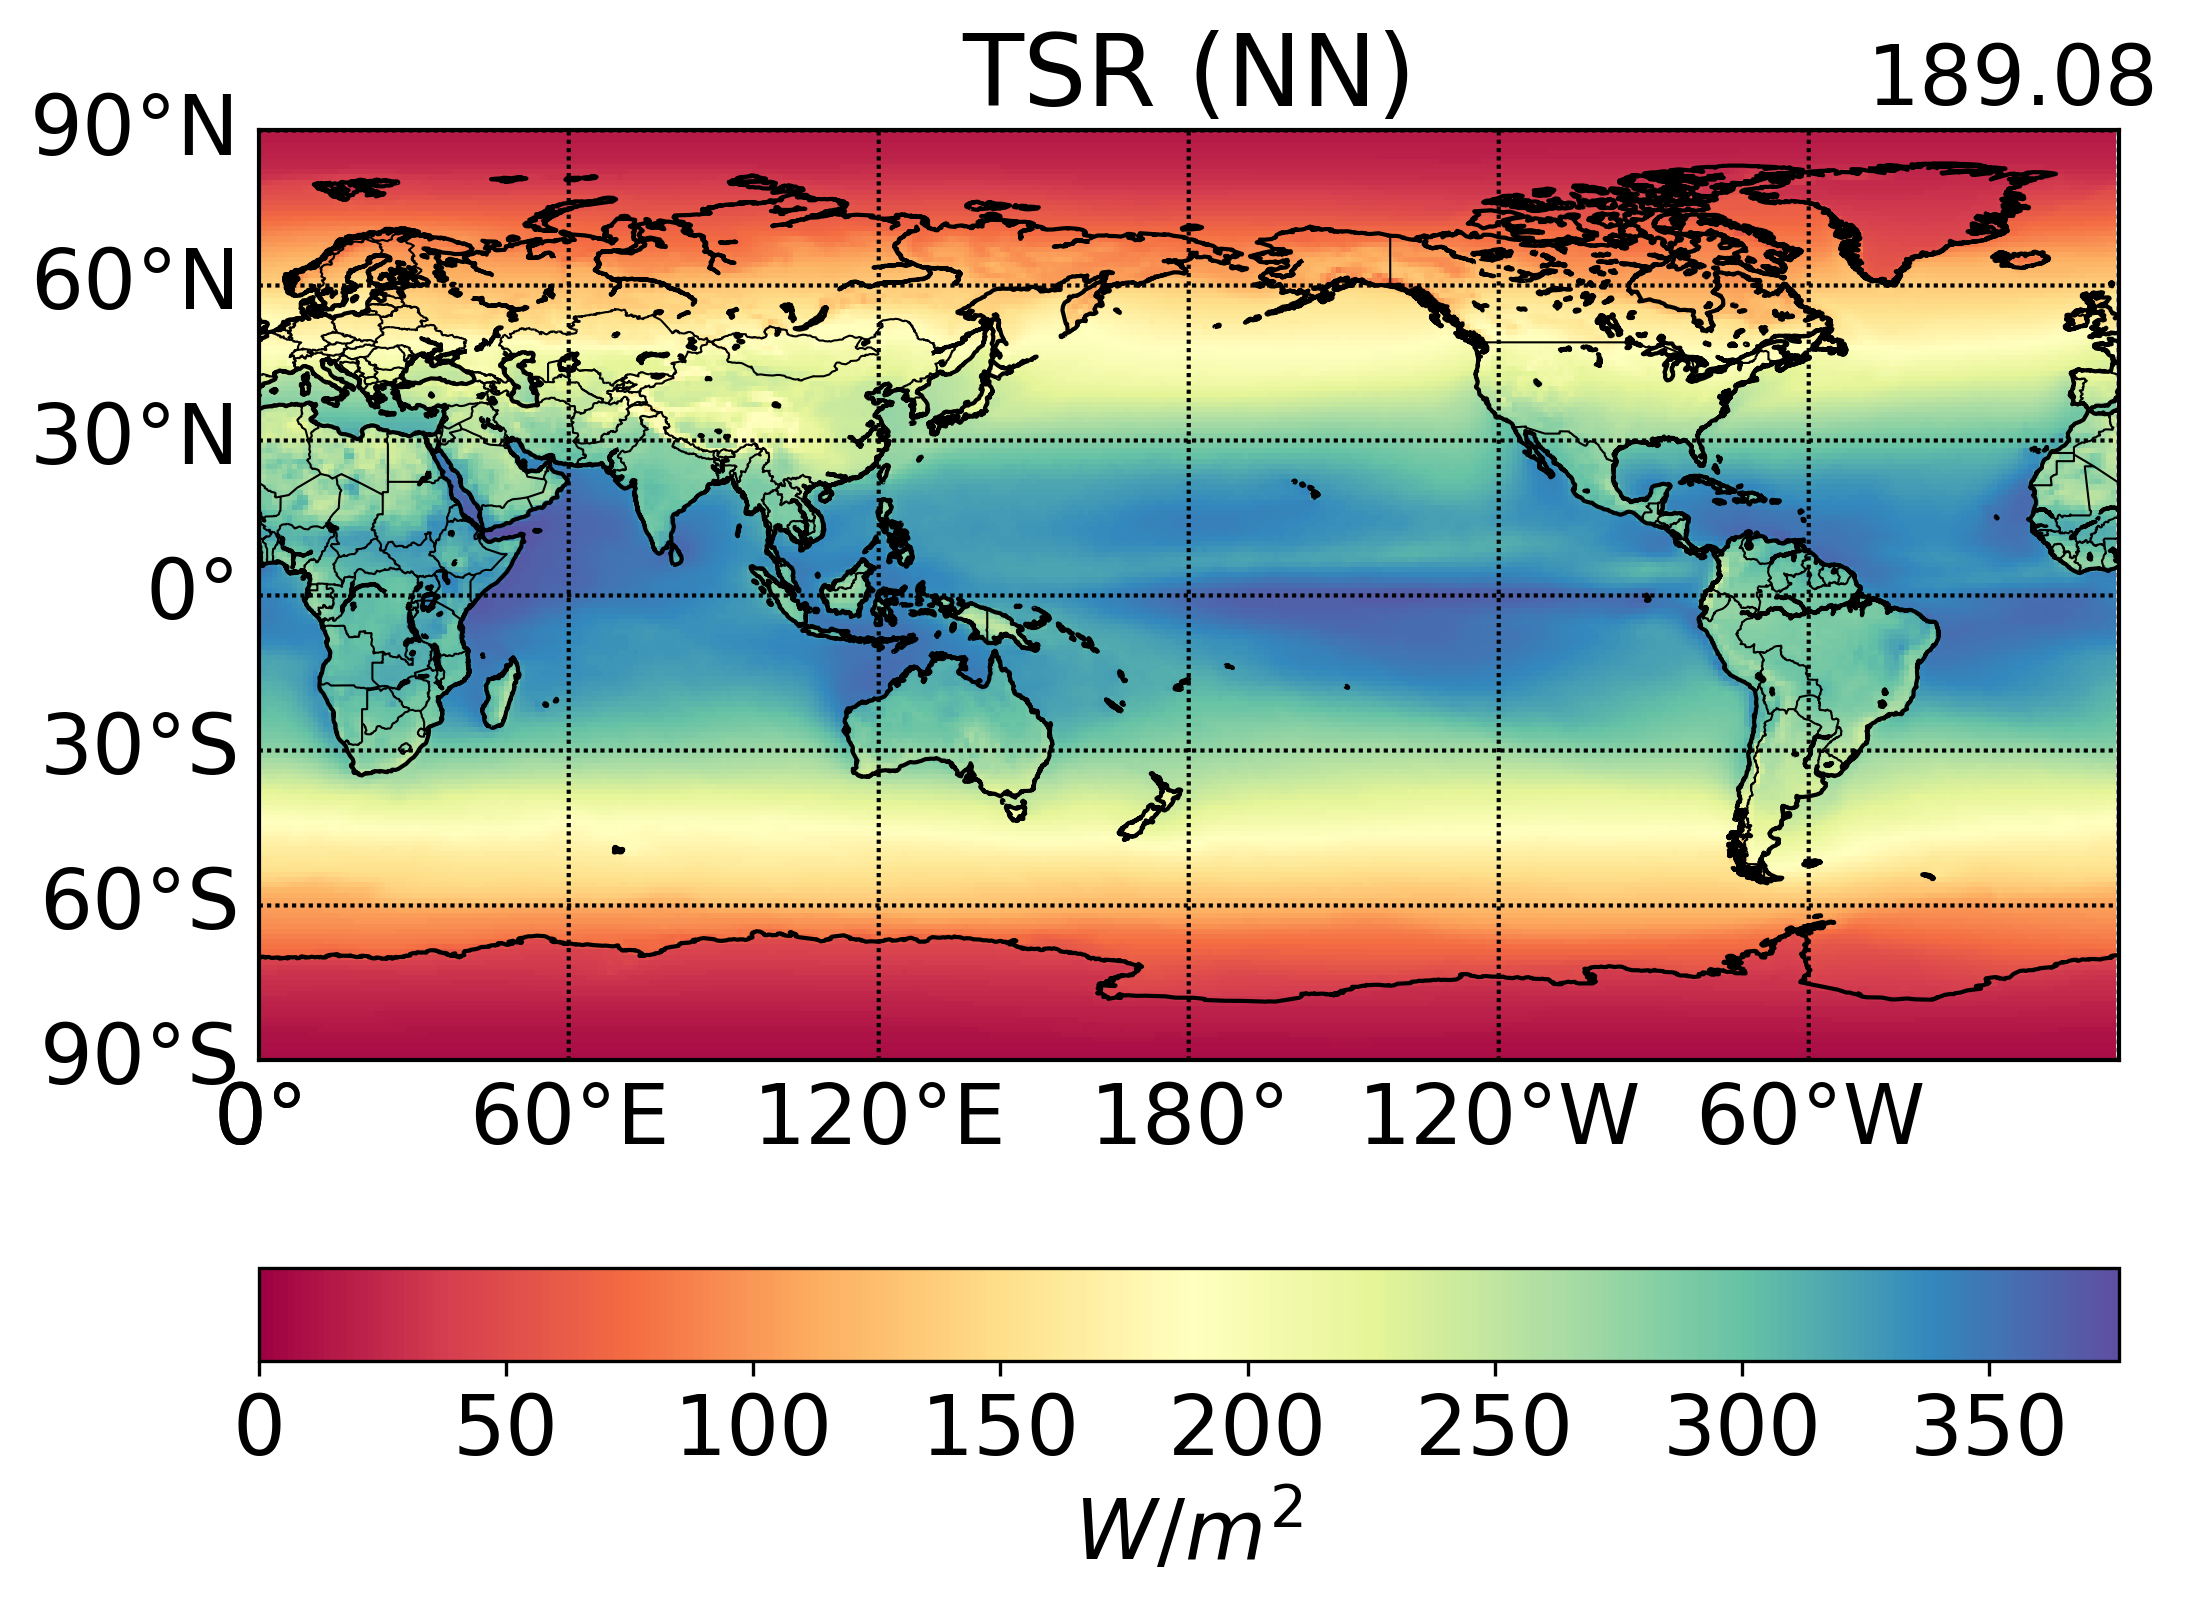

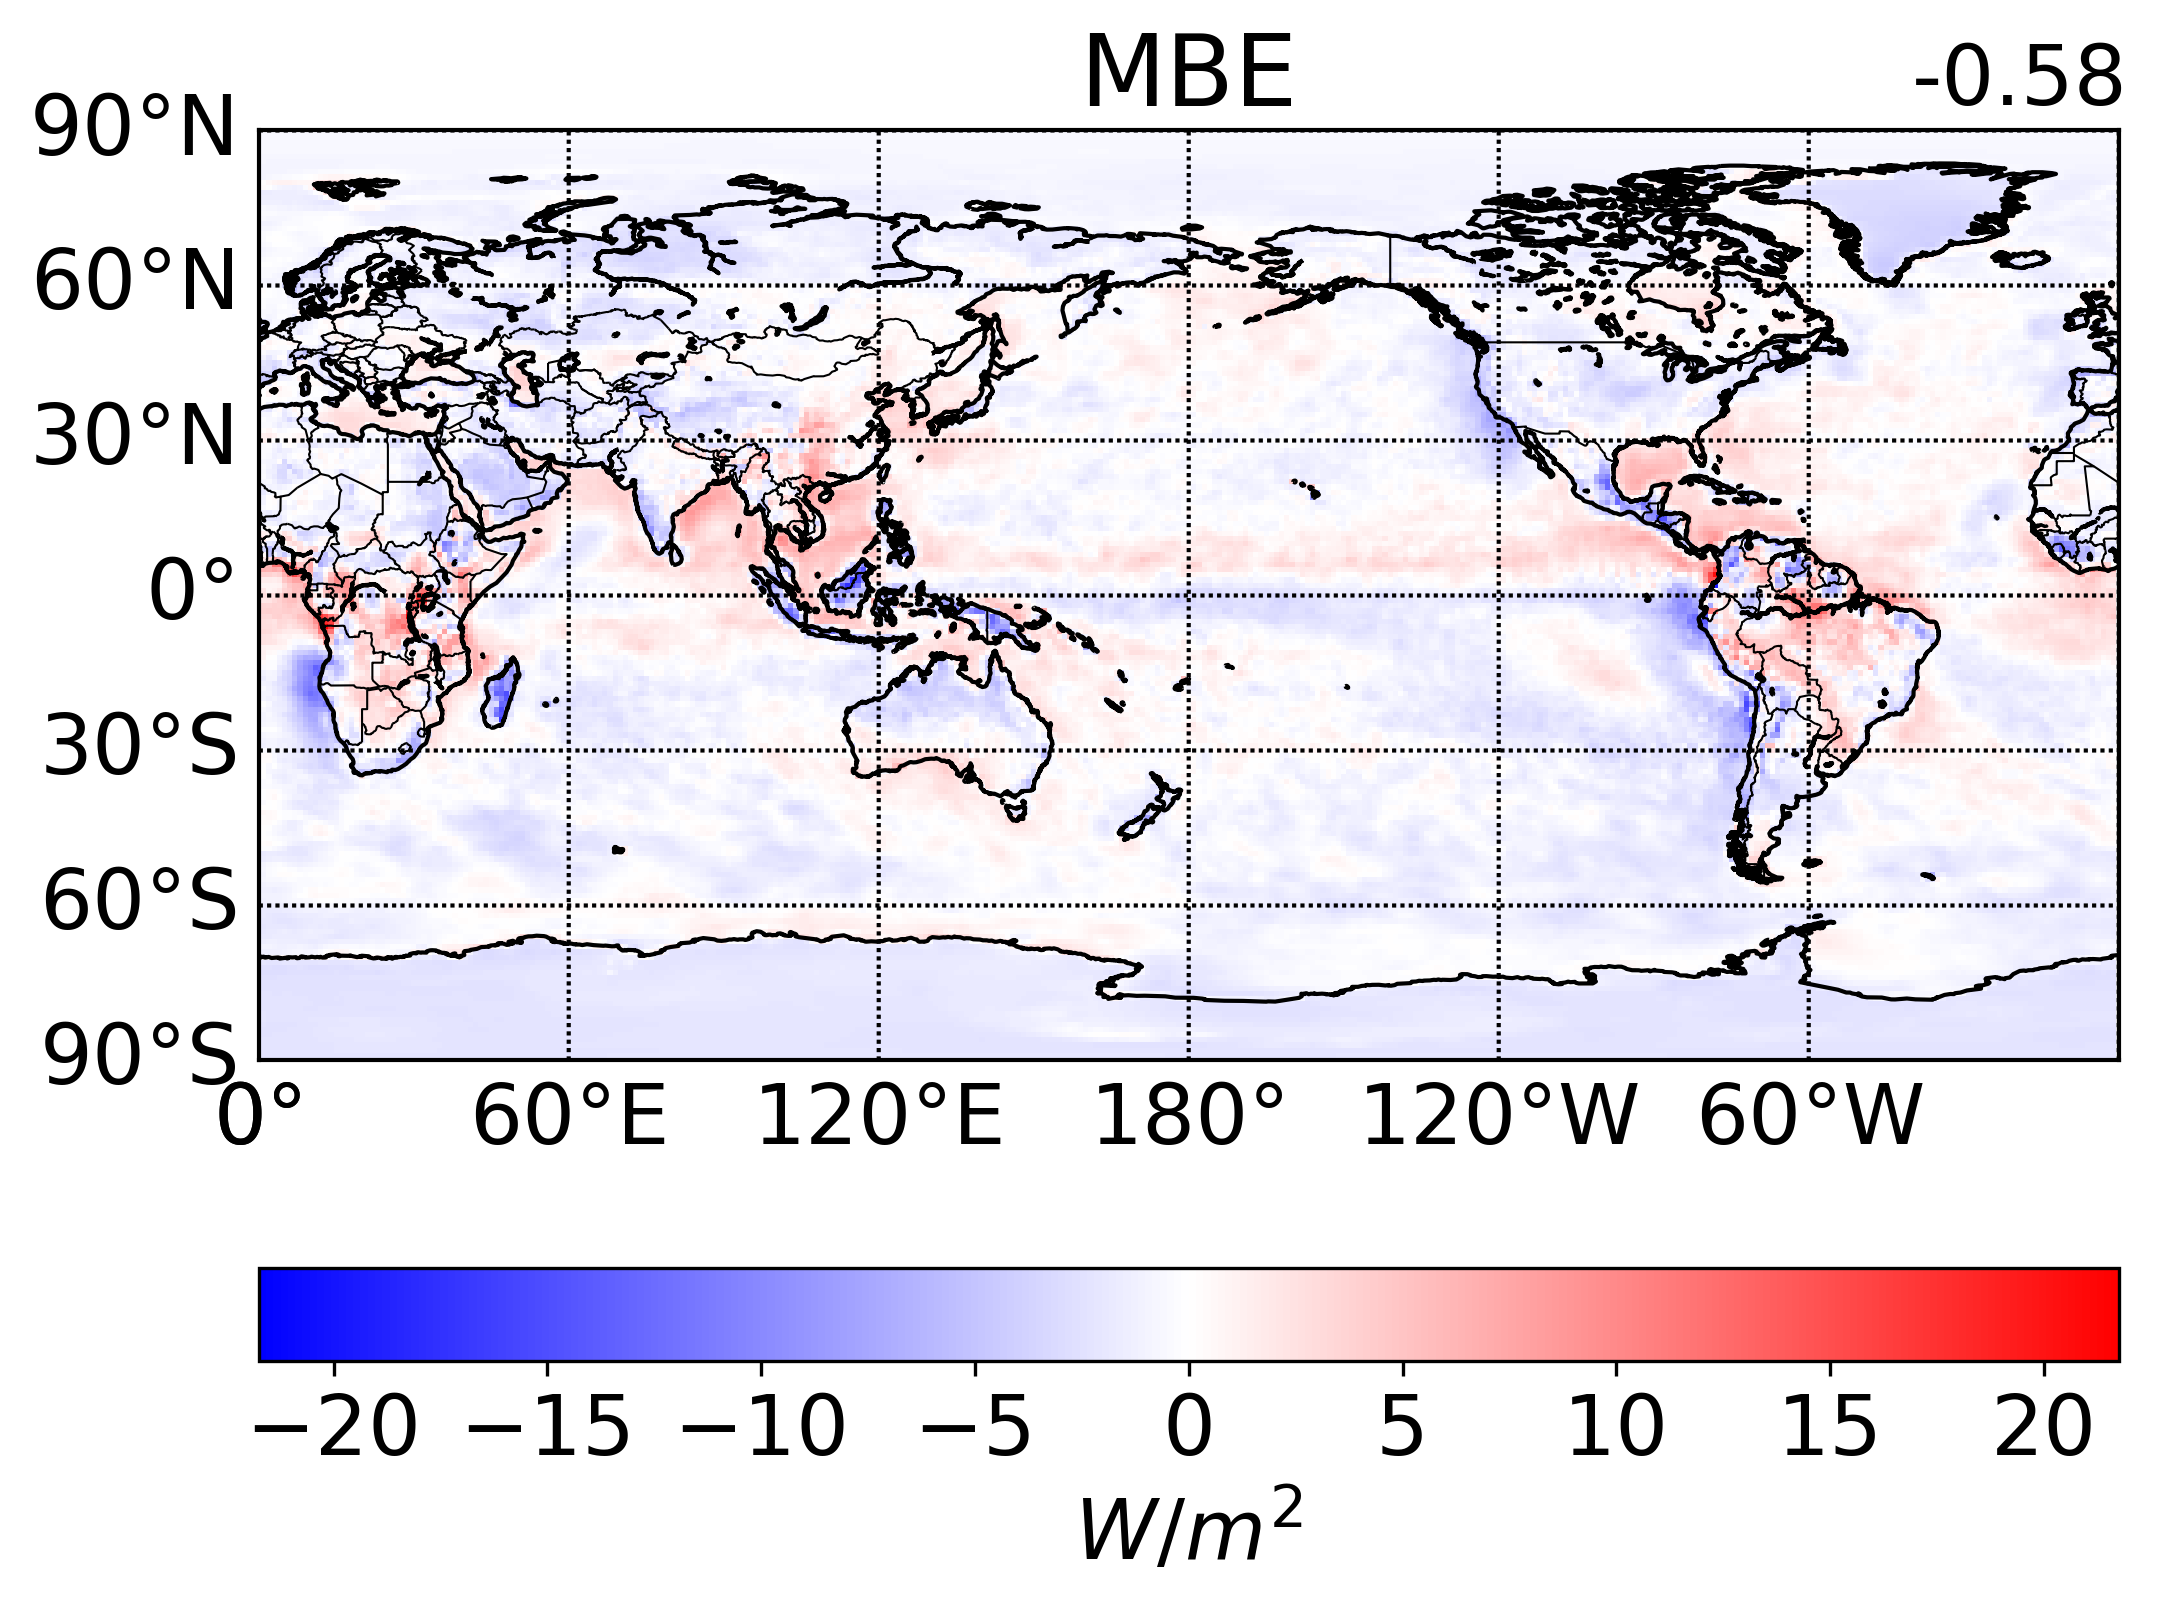

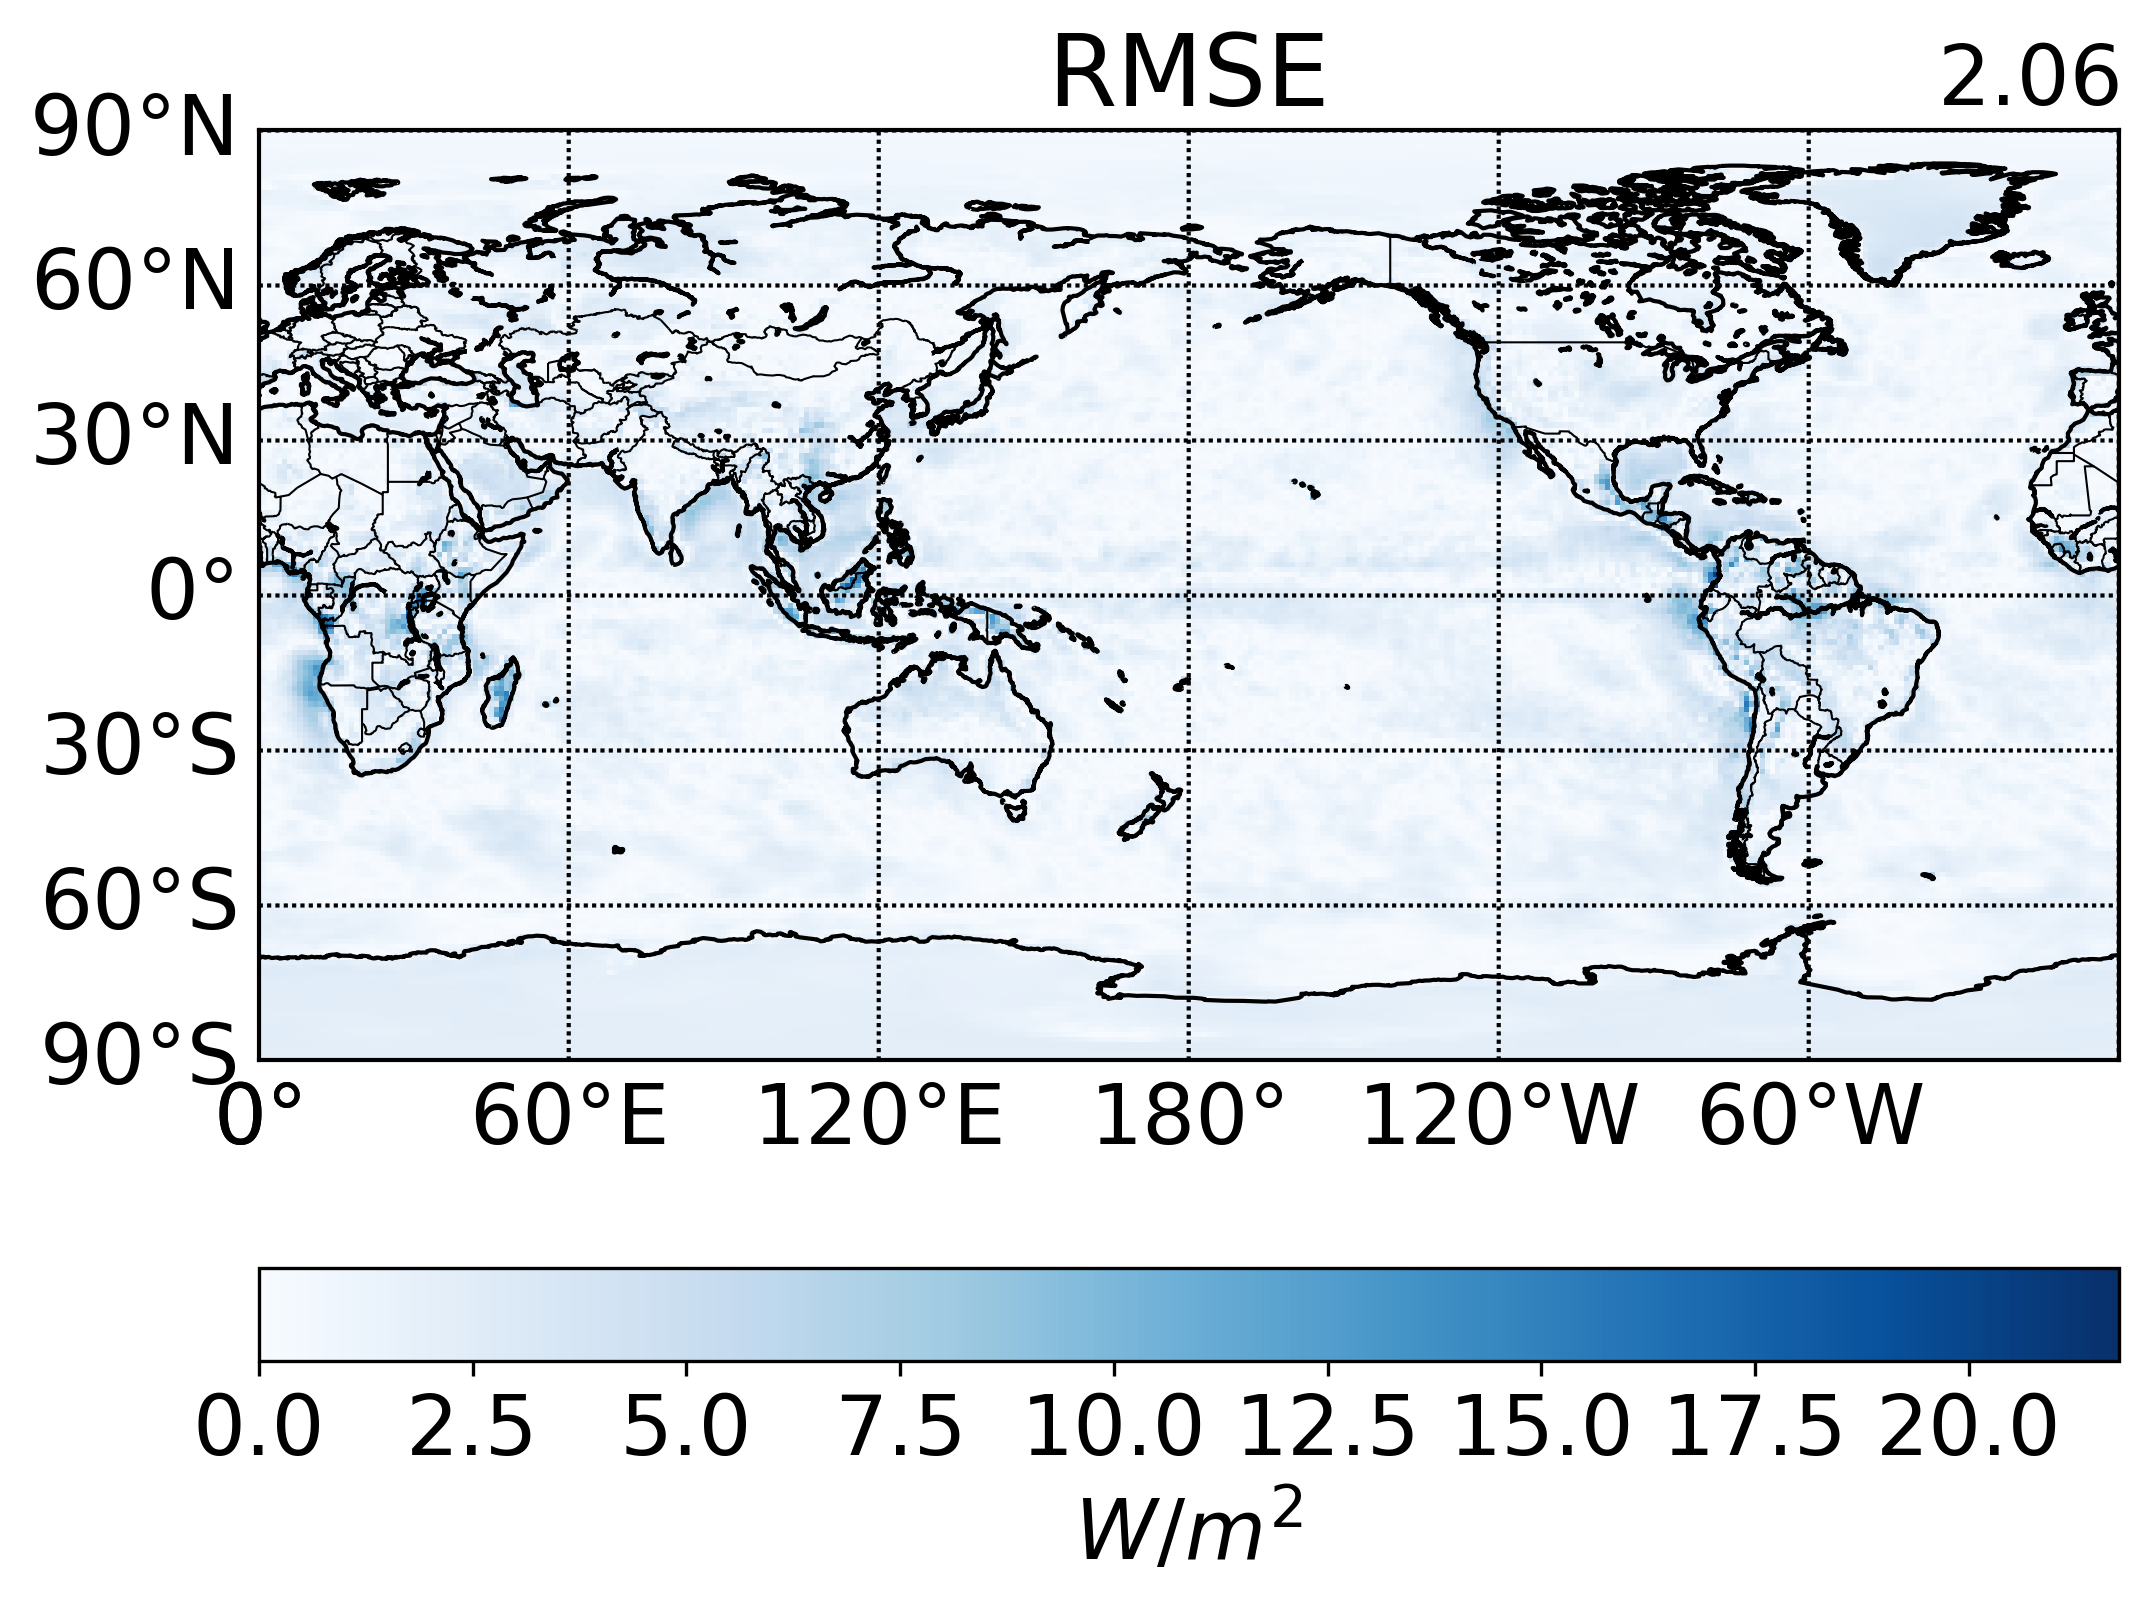

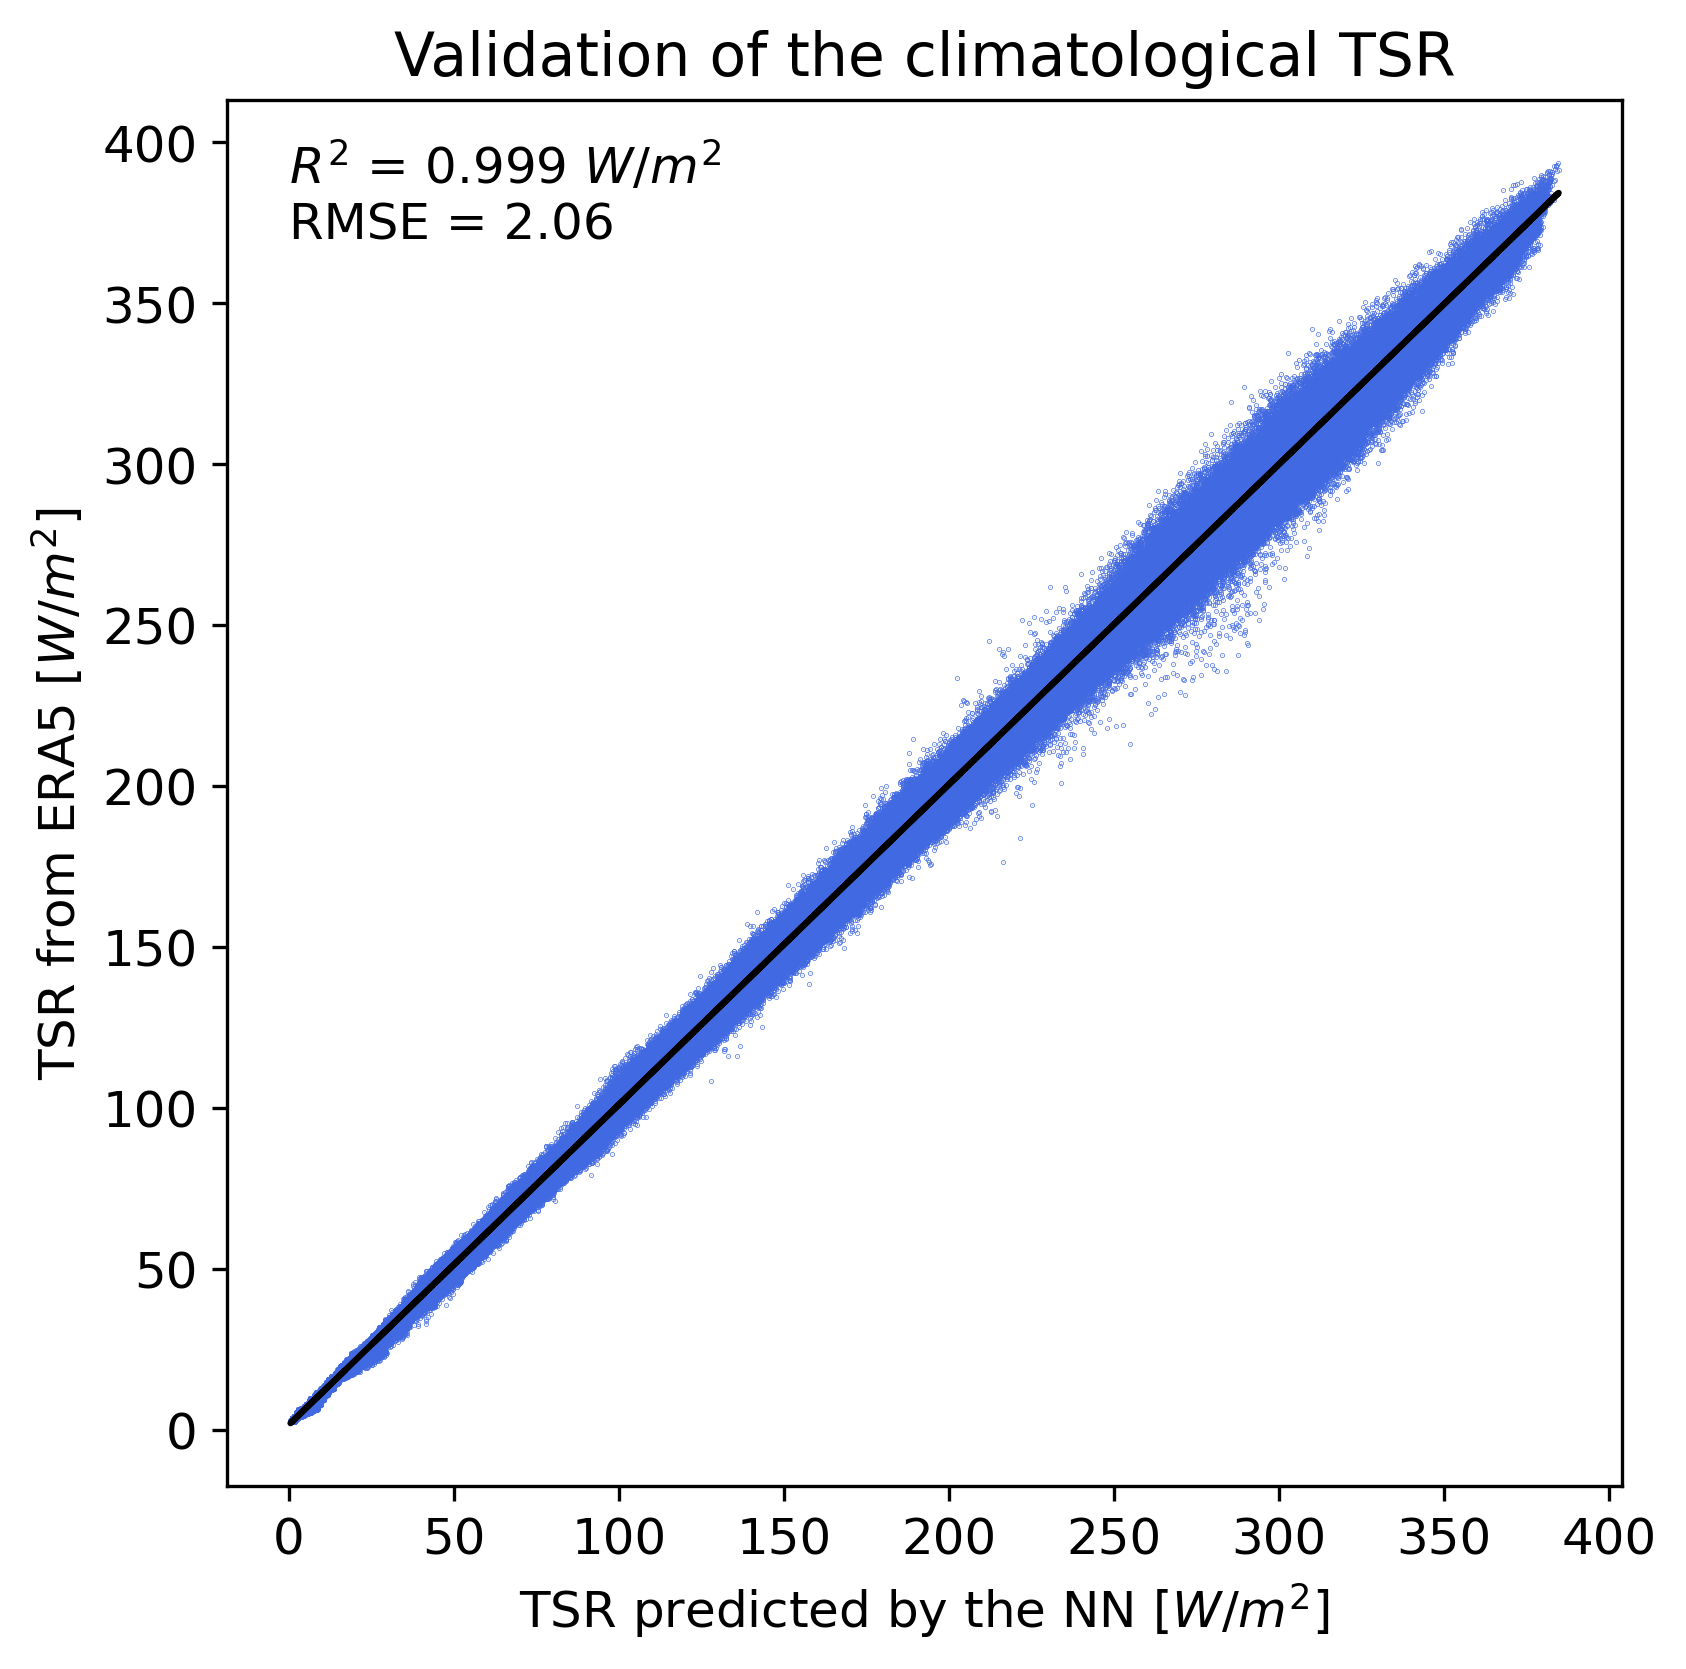

In [3]:
 ################################################
#    Script to test the global neural network    #
#                 By: Diana Diaz                 #
 ################################################

## ML libraries
# tensorflow
import tensorflow as tf
from tensorflow import keras

## import general libraries
import os,sys,glob
import numpy as np
import xarray as xr

## import libraries for plots
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd

from mpl_toolkits.basemap import Basemap

import matplotlib as mpl
from scipy.stats import linregress
# Set the font size globally
font_size = 20
mpl.rcParams['font.size'] = font_size

#global_nn_model/nn_train/train6/nn_saved_model'
path_saved_model = '/content/data/Data for Quantification of Shortwave Surface Albedo Feedback using a Neural Network Approach/data/nn_saved_model'
model = keras.models.load_model(path_saved_model)

## import data
# single levels data including effective cloud optical depth variable
path = '/content/data/Data for Quantification of Shortwave Surface Albedo Feedback using a Neural Network Approach/data/'
file_sl = 'era5_1deg_monthly_avg_sl_1990-2020_tisr_tciw_tclw_tcwv_hcc_mcc_lcc_sp_tco3_fal_tsr_msl_ecod_noZeros.nc'
xrr_sl = xr.open_dataset(path+file_sl)

#To convert to W m-2 , the accumulated values should be divided by the accumulation period expressed in seconds
xrr_sl['tisr'] = xrr_sl.tisr/24/3600
xrr_sl['tsr'] =xrr_sl.tsr/24/3600

#xrr_sl['tsr'] = xr.where(xrr_sl.tsr < 0, np.nan, xrr_sl.tsr)
#xrr_sl['tisr'] = xr.where(xrr_sl.tisr < 0, np.nan, xrr_sl.tisr)

## divide datasets for training and testing
# extract the years from the time dimension
years = xrr_sl['time.year']

# select odd years
#odd years for testing
xrr_sl_odd = xrr_sl.sel(time=(years % 2 == 1))

# select even years
#even years for trainning
xrr_sl_even = xrr_sl.sel(time=(years % 2 == 0))

## We test the NN with the odd years
df_test = xrr_sl_odd.to_dataframe()
vars_list_test =  [ np.array(df_test.tisr), np.array(df_test.tciw), np.array(df_test.tclw), np.array(df_test.tcwv),
                   np.array(df_test.lcc), np.array(df_test.mcc), np.array(df_test.hcc), np.array(df_test.sp),
                   np.array(df_test.tco3), np.array(df_test.fal),np.array(df_test.ecod),
                   np.array(df_test.ecod*df_test.fal)]

tsr_test = np.array(df_test.tsr)

max_val_test = np.round(np.max(tsr_test),2)
min_val_test = np.round(np.min(tsr_test),2)

# Normalization range [a,b]
#We set the normalization rate to be between -1 and 1, since the activation function (tanh) has the same range
a = -1
b = 1
nrmlzd_vars_list_test = []
for x in vars_list_test:
    n = MinMaxNorm(x,a,b)
    nrmlzd_vars_list_test.append(n)

#we combine the input variables into one merged array
merged_array_test = np.stack((nrmlzd_vars_list_test), axis=1) #da.stack((nrmlzd_vars_list), axis=1)
xx_test = merged_array_test
yy_test = MinMaxNorm(tsr_test,a,b) #we normalize the output

#predictions
prdctns=model.predict(xx_test)
#inverse transform
prdctnss = MinMaxInverse(prdctns,a,b,df_test.tsr)
#df_lat_lon = df_test.reset_index(level = ['lon','lat'])
#df_lat_lon['NN_prdctns'] = prdctnss
#df_lat_lon.to_csv('dataset_nn_test.csv')

df_test['NN_prdctns'] = prdctnss

# Convert DataFrame to xarray Dataset
dataset = xr.Dataset.from_dataframe(df_test.squeeze())

tsr_mean = dataset['tsr'].mean(dim='time')
tsr_mean = tsr_mean.transpose()
TSR = np.round(np.mean(tsr_mean),2)
TSR_str = str(TSR.values)
TSR_plot = TSR_str

nnPred_mean = dataset['NN_prdctns'].mean(dim='time')
nnPred_mean = nnPred_mean.transpose()
NN_TSR = np.round(np.mean(nnPred_mean),2)
NN_TSR_str = str(NN_TSR.values)
NN_TSR_plot = NN_TSR_str

if np.max(tsr_mean)> np.max(nnPred_mean):
    max_val = np.max(tsr_mean)
else:
    max_val = np.max(nnPred_mean)

fig = plt.figure(figsize=(8, 6),dpi=300)

m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=0, urcrnrlon=360)


lon, lat = dataset['lon'].values, dataset['lat'].values
lon, lat = np.meshgrid(lon, lat)
x, y = m(lon, lat)
m.pcolormesh(x, y, tsr_mean, shading='nearest', cmap='Spectral',vmin=0,vmax=max_val)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()

# Draw parallels (latitude lines) and meridians (longitude lines) with labels
parallels = np.arange(-90., 91., 30.)  # Define the latitude lines you want to draw
meridians = np.arange(-180., 181., 60.)  # Define the longitude lines you want to draw
m.drawparallels(parallels, labels=[True, False, False, True])  # Draw latitude lines with labels on left and right
m.drawmeridians(meridians, labels=[True, False, False, True])  # Draw longitude lines with labels on top and bottom

plt.text(np.max(tsr_mean)-65, np.max(dataset['lat'].values)+5 , TSR_plot, fontsize=20)
plt.colorbar(orientation='horizontal', fraction=0.075, label='$W/m^2$')
plt.title('TSR (ERA5)')

#plt.show()
plt.savefig('tsr_test.png')

fig = plt.figure(figsize=(8, 6),dpi=300)

m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=0, urcrnrlon=360)


lon, lat = dataset['lon'].values, dataset['lat'].values
lon, lat = np.meshgrid(lon, lat)
x, y = m(lon, lat)
m.pcolormesh(x, y, nnPred_mean, shading='nearest', cmap='Spectral', vmin =0,vmax= max_val ) # ,vmin= -120, vmax=40 )

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()

# Draw parallels (latitude lines) and meridians (longitude lines) with labels
parallels = np.arange(-90., 91., 30.)  # Define the latitude lines you want to draw
meridians = np.arange(-180., 181., 60.)  # Define the longitude lines you want to draw
m.drawparallels(parallels, labels=[True, False, False, True])  # Draw latitude lines with labels on left and right
m.drawmeridians(meridians, labels=[True, False, False, True])  # Draw longitude lines with labels on top and bottom

plt.text(np.max(nnPred_mean)-65, np.max(dataset['lat'].values)+5 , NN_TSR_plot, fontsize=20)
plt.colorbar(orientation='horizontal', fraction=0.075, label='$W/m^2$')

plt.title('TSR (NN)')

#plt.show()
plt.savefig('nn_prdctns.png')



difference = nnPred_mean - tsr_mean

if abs(np.min(difference))>abs(np.max(difference)):
    value = abs(np.min(difference))
else:
    value = abs(np.max(difference))

MBE = np.round(np.mean(difference),2)
MBE_str = str(MBE.values)
MBE_plot = MBE_str


fig = plt.figure(figsize=(8, 6),dpi=300)

m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=0, urcrnrlon=360)

lon, lat = dataset['lon'].values, dataset['lat'].values
lon, lat = np.meshgrid(lon, lat)
x, y = m(lon, lat)
m.pcolormesh(x, y, difference, shading='nearest', cmap='bwr' ,vmin =-value,vmax=value)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()

# Draw parallels (latitude lines) and meridians (longitude lines) with labels
parallels = np.arange(-90., 91., 30.)  # Define the latitude lines you want to draw
meridians = np.arange(-180., 181., 60.)  # Define the longitude lines you want to draw
m.drawparallels(parallels, labels=[True, False, False, True])  # Draw latitude lines with labels on left and right
m.drawmeridians(meridians, labels=[True, False, False, True])  # Draw longitude lines with labels on top and bottom

plt.text(320, np.max(dataset['lat'].values)+5 , MBE_plot, fontsize=20)
plt.colorbar(orientation='horizontal', fraction=0.075, label='$W/m^2$')

plt.title('MBE')

#plt.show()
plt.savefig('mbe.png')


rmse_plot = np.sqrt((difference)**2)

RMSE = np.round(np.sqrt(np.mean((difference)**2)),2)
RMSE_str = str(RMSE.values)
RMSE_plot = RMSE_str

fig = plt.figure(figsize=(8, 6),dpi=300)

m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=0, urcrnrlon=360)


lon, lat = dataset['lon'].values, dataset['lat'].values
lon, lat = np.meshgrid(lon, lat)
x, y = m(lon, lat)
m.pcolormesh(x, y, rmse_plot, shading='nearest', cmap='Blues' ,vmin =0,vmax=np.max(rmse_plot))

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()

# Draw parallels (latitude lines) and meridians (longitude lines) with labels
parallels = np.arange(-90., 91., 30.)  # Define the latitude lines you want to draw
meridians = np.arange(-180., 181., 60.)  # Define the longitude lines you want to draw
m.drawparallels(parallels, labels=[True, False, False, True])  # Draw latitude lines with labels on left and right
m.drawmeridians(meridians, labels=[True, False, False, True])  # Draw longitude lines with labels on top and bottom

plt.text(325, np.max(dataset['lat'].values)+5 , RMSE_plot, fontsize=20)
plt.colorbar(orientation='horizontal', fraction=0.075, label='$W/m^2$')

plt.title('RMSE')

#plt.show()
plt.savefig('rmse.png')


slope, intercept, r_value, p_value, std_err = linregress(prdctnss.squeeze(), tsr_test)

r2 = r_value**2
r_squared= np.round(r2,3)
r_squared_str = str(r_squared)
r_squared_plot = r_squared_str+' $W/m^2$'

mse = np.mean((tsr_test-prdctnss.squeeze())**2)
rmse = np.sqrt(mse)

val_str = '$R^2$ = '+ r_squared_plot+' \nRMSE = ' + RMSE_plot

mpl.rcParams['font.size'] = 12

plt.figure(figsize=(6, 6), dpi=300) #80

# Create a diagonal line royalblue
plt.plot(prdctnss.squeeze(), np.array(prdctnss.squeeze()) * slope + intercept, color='k')
plt.scatter(prdctnss,tsr_test,color='royalblue', marker = '.',s=0.1)

plt.ylabel('TSR from ERA5 $[W/m^2$]')
plt.xlabel('TSR predicted by the NN [$W/m^2$]')
plt.title('Validation of the climatological TSR')
plt.text(0, 370, val_str, fontsize=12)
plt.savefig('validation.png')

# saving metrics in txt file
file_txt = "metrics.txt"
file = open(file_txt, "w")

file.write('MBE = {}\n'.format(MBE_str))
file.write('RMSE = {}\n'.format(RMSE_str))
file.write('TSR = {}\n'.format(TSR_str))
file.write('NN_TSR = {}\n'.format(NN_TSR_str))

file.close()

# Training the model!

Model: "Sequential_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hiddenLayer1 (Dense)        (None, 11)                143       
                                                                 
 output (Dense)              (None, 1)                 12        
                                                                 
Total params: 155
Trainable params: 155
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
65160/65160 - 87s - loss: 0.0015 - root_mean_squared_error: 0.0387 - 87s/epoch - 1ms/step
Epoch 2/3
65160/65160 - 87s - loss: 4.2787e-04 - root_mean_squared_error: 0.0207 - 87s/epoch - 1ms/step
Epoch 3/3
65160/65160 - 82s - loss: 4.1209e-04 - root_mean_squared_error: 0.0203 - 82s/epoch - 1ms/step


--- 256.99938225746155 seconds ---


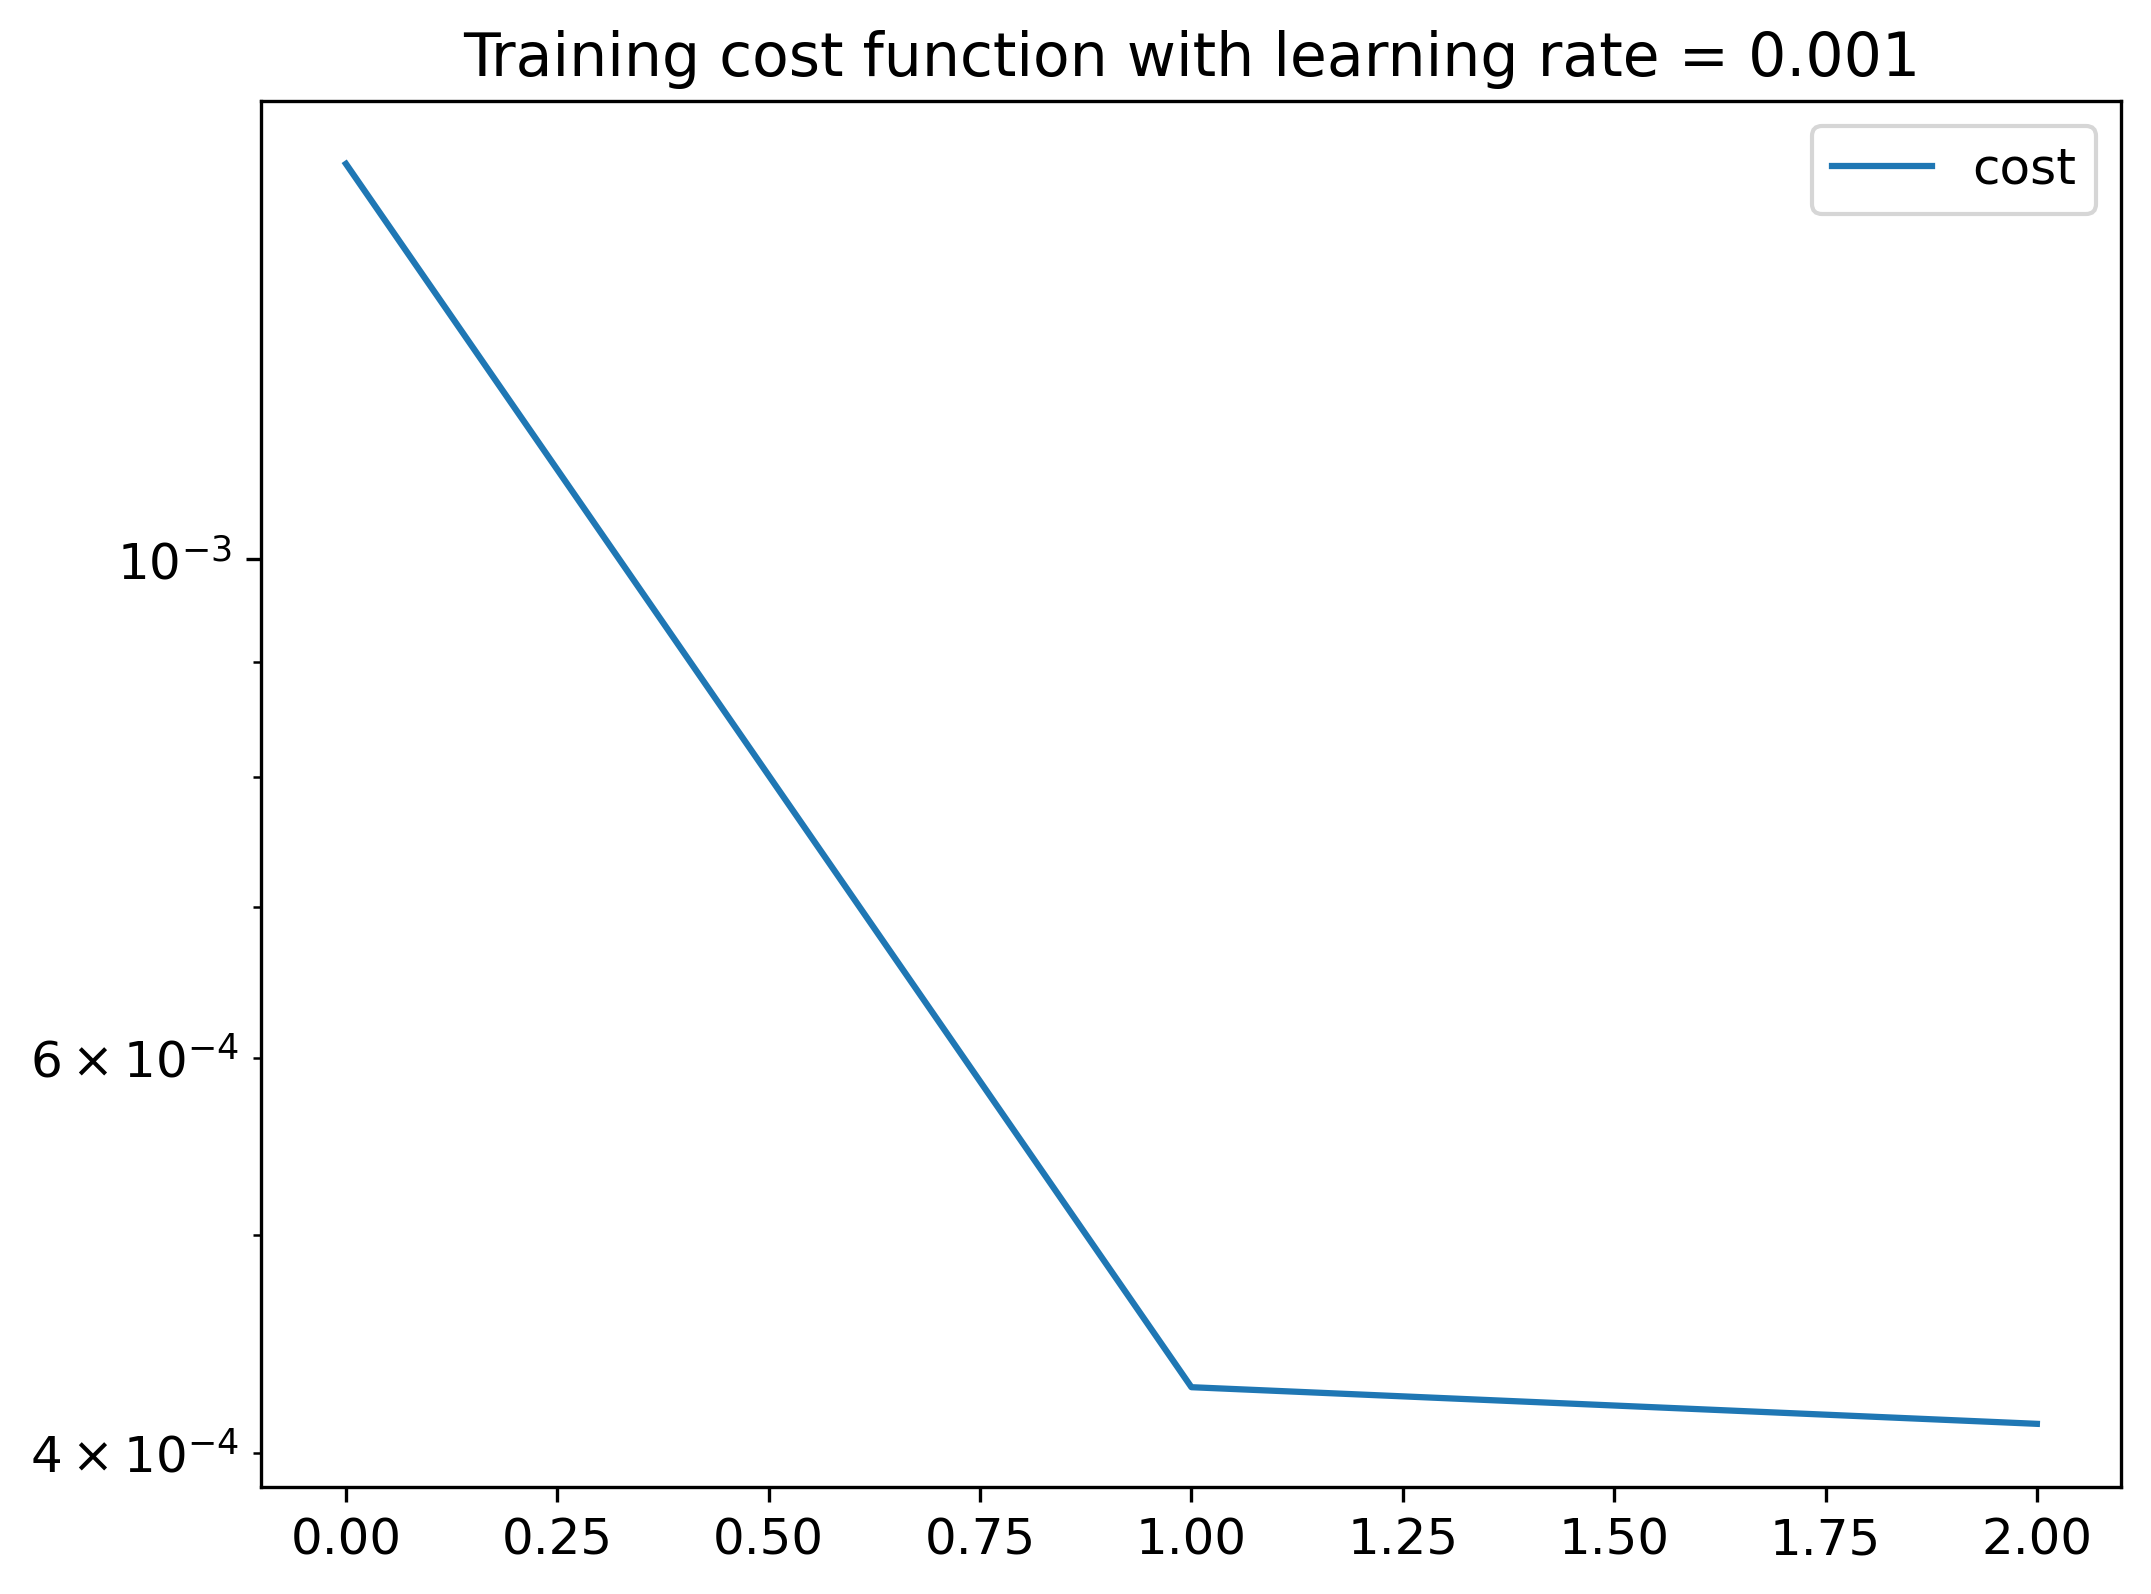

In [6]:
 ################################################
#    Script to train the global neural network   #
#                 By: Diana Diaz                 #
 ################################################

## import general libraries
import os,sys,glob
import numpy as np
import pandas as pd
import xarray as xr
import math
import time

## import libraries for plots
import matplotlib.pyplot as plt
import matplotlib as mpl

# sklearn libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

## ML libraries
# tensorflow
import tensorflow as tf
from tensorflow import keras
# keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from keras.utils.vis_utils import plot_model #CHANGE
#from keras.utils import plot_model #LAPTOP
import keras.backend as K
from tensorflow.python.training import checkpoint_utils as cp

## extra libraries
#!pip install ann_visualizer

from ann_visualizer.visualize import ann_viz
from itertools import chain
from mpl_toolkits import mplot3d
from sympy import symbols
from sympy.utilities.lambdify import lambdify

#import functions


## we define the parameters for the NN configuration
lr = 0.001
itrtns = 3
ndsLyr1 =11
ndsLyr2 =0
act_fnctn1 = 'tanh'
act_fnctn2 = 0
earlyStppng = 1                        # No = 0 , Yes = 1
ptnce = 10                            #100
lossTHR = 0.00002                      #0.00003

## set the font size globally
font_size = 12
mpl.rcParams['font.size'] = font_size

## import data
# single levels data including effective cloud optical depth variable
path = '/content/data/Data for Quantification of Shortwave Surface Albedo Feedback using a Neural Network Approach/data/'
file_sl = 'era5_1deg_monthly_avg_sl_1990-2020_tisr_tciw_tclw_tcwv_hcc_mcc_lcc_sp_tco3_fal_tsr_msl_ecod_noZeros.nc'
xrr_sl = xr.open_dataset(path+file_sl)

#To convert to W m-2 , the accumulated values should be divided by the accumulation period expressed in seconds
xrr_sl['tisr'] = xrr_sl.tisr/24/3600
xrr_sl['tsr'] =xrr_sl.tsr/24/3600

## divide datasets for training and testing
# extract the years from the time dimension
years = xrr_sl['time.year']

# select odd years
#odd years for testing
xrr_sl_odd = xrr_sl.sel(time=(years % 2 == 1))

# select even years
#even years for trainning
xrr_sl_even = xrr_sl.sel(time=(years % 2 == 0))

df_train = xrr_sl_even.to_dataframe()

#### Input variables
vars_list = [np.array(df_train.tisr), np.array(df_train.tciw), np.array(df_train.tclw), np.array(df_train.tcwv),
             np.array(df_train.lcc), np.array(df_train.mcc), np.array(df_train.hcc), np.array(df_train.sp),
             np.array(df_train.tco3), np.array(df_train.fal), np.array(df_train.ecod),
             np.array(df_train.ecod)*np.array(df_train.fal)
            ]

vars_list_str = ['tisr', 'tciw', 'tclw', 'tcwv', 'lcc', 'mcc', 'hcc', 'sp', 'tco3' , 'fal','ecod','ecod_alb']

#### Output variable
tsr = np.array(df_train.tsr)
max_val = np.round(np.max(tsr),2)
min_val = np.round(np.min(tsr),2)

# Normalization range [a,b]
#We set the normalization rate to be between -1 and 1, since the activation function (tanh) has the same range
a = -1
b = 1

nrmlzd_vars_list = []
for x in vars_list:
    n = MinMaxNorm(x,a,b)
    nrmlzd_vars_list.append(n)

#we combine the input variables into one merged array
merged_array = np.stack((nrmlzd_vars_list), axis=1) #da.stack((nrmlzd_vars_list), axis=1)

### we define here the input and output variables for the NN
xx = merged_array   #the input variables are already normalized
yy = MinMaxNorm(tsr,a,b) #we normalize the output

#### new early stopping method

from keras.callbacks import Callback

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current <= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True


### Training
tf.random.set_seed(6)
shp_inpt = merged_array.shape[1]

model,history_df,weights_dict = runNN(xx, yy,
                                    alpha=lr,
                                    iterations=itrtns,
                                    shape_input=shp_inpt,
                                    nodesLayer1=ndsLyr1,
                                    nodesLayer2=ndsLyr2,
                                    act_function1=act_fnctn1,
                                    act_function2=act_fnctn2,
                                    earlyStopping=earlyStppng,
                                    patienceEpochs=ptnce,
                                    loss_thr=lossTHR ) #we define the loss threshold but we are not using it

model.save('nn_saved_model')
nds_num = ndsLyr1
inpt_num = shp_inpt
inpt_list = vars_list_str
act_func = 'tanh'

equation = build_nn_eq(nds_num,inpt_num,inpt_list,act_func,model)

Epoch 1/2
65160/65160 [==============================] - 196s 3ms/step - loss: 5.3072e-04 - val_loss: 5.4034e-04
Epoch 2/2
65160/65160 [==============================] - 195s 3ms/step - loss: 3.7772e-04 - val_loss: 3.4891e-04


61088/61088 [==============================] - 80s 1ms/step
Training and evaluation completed!


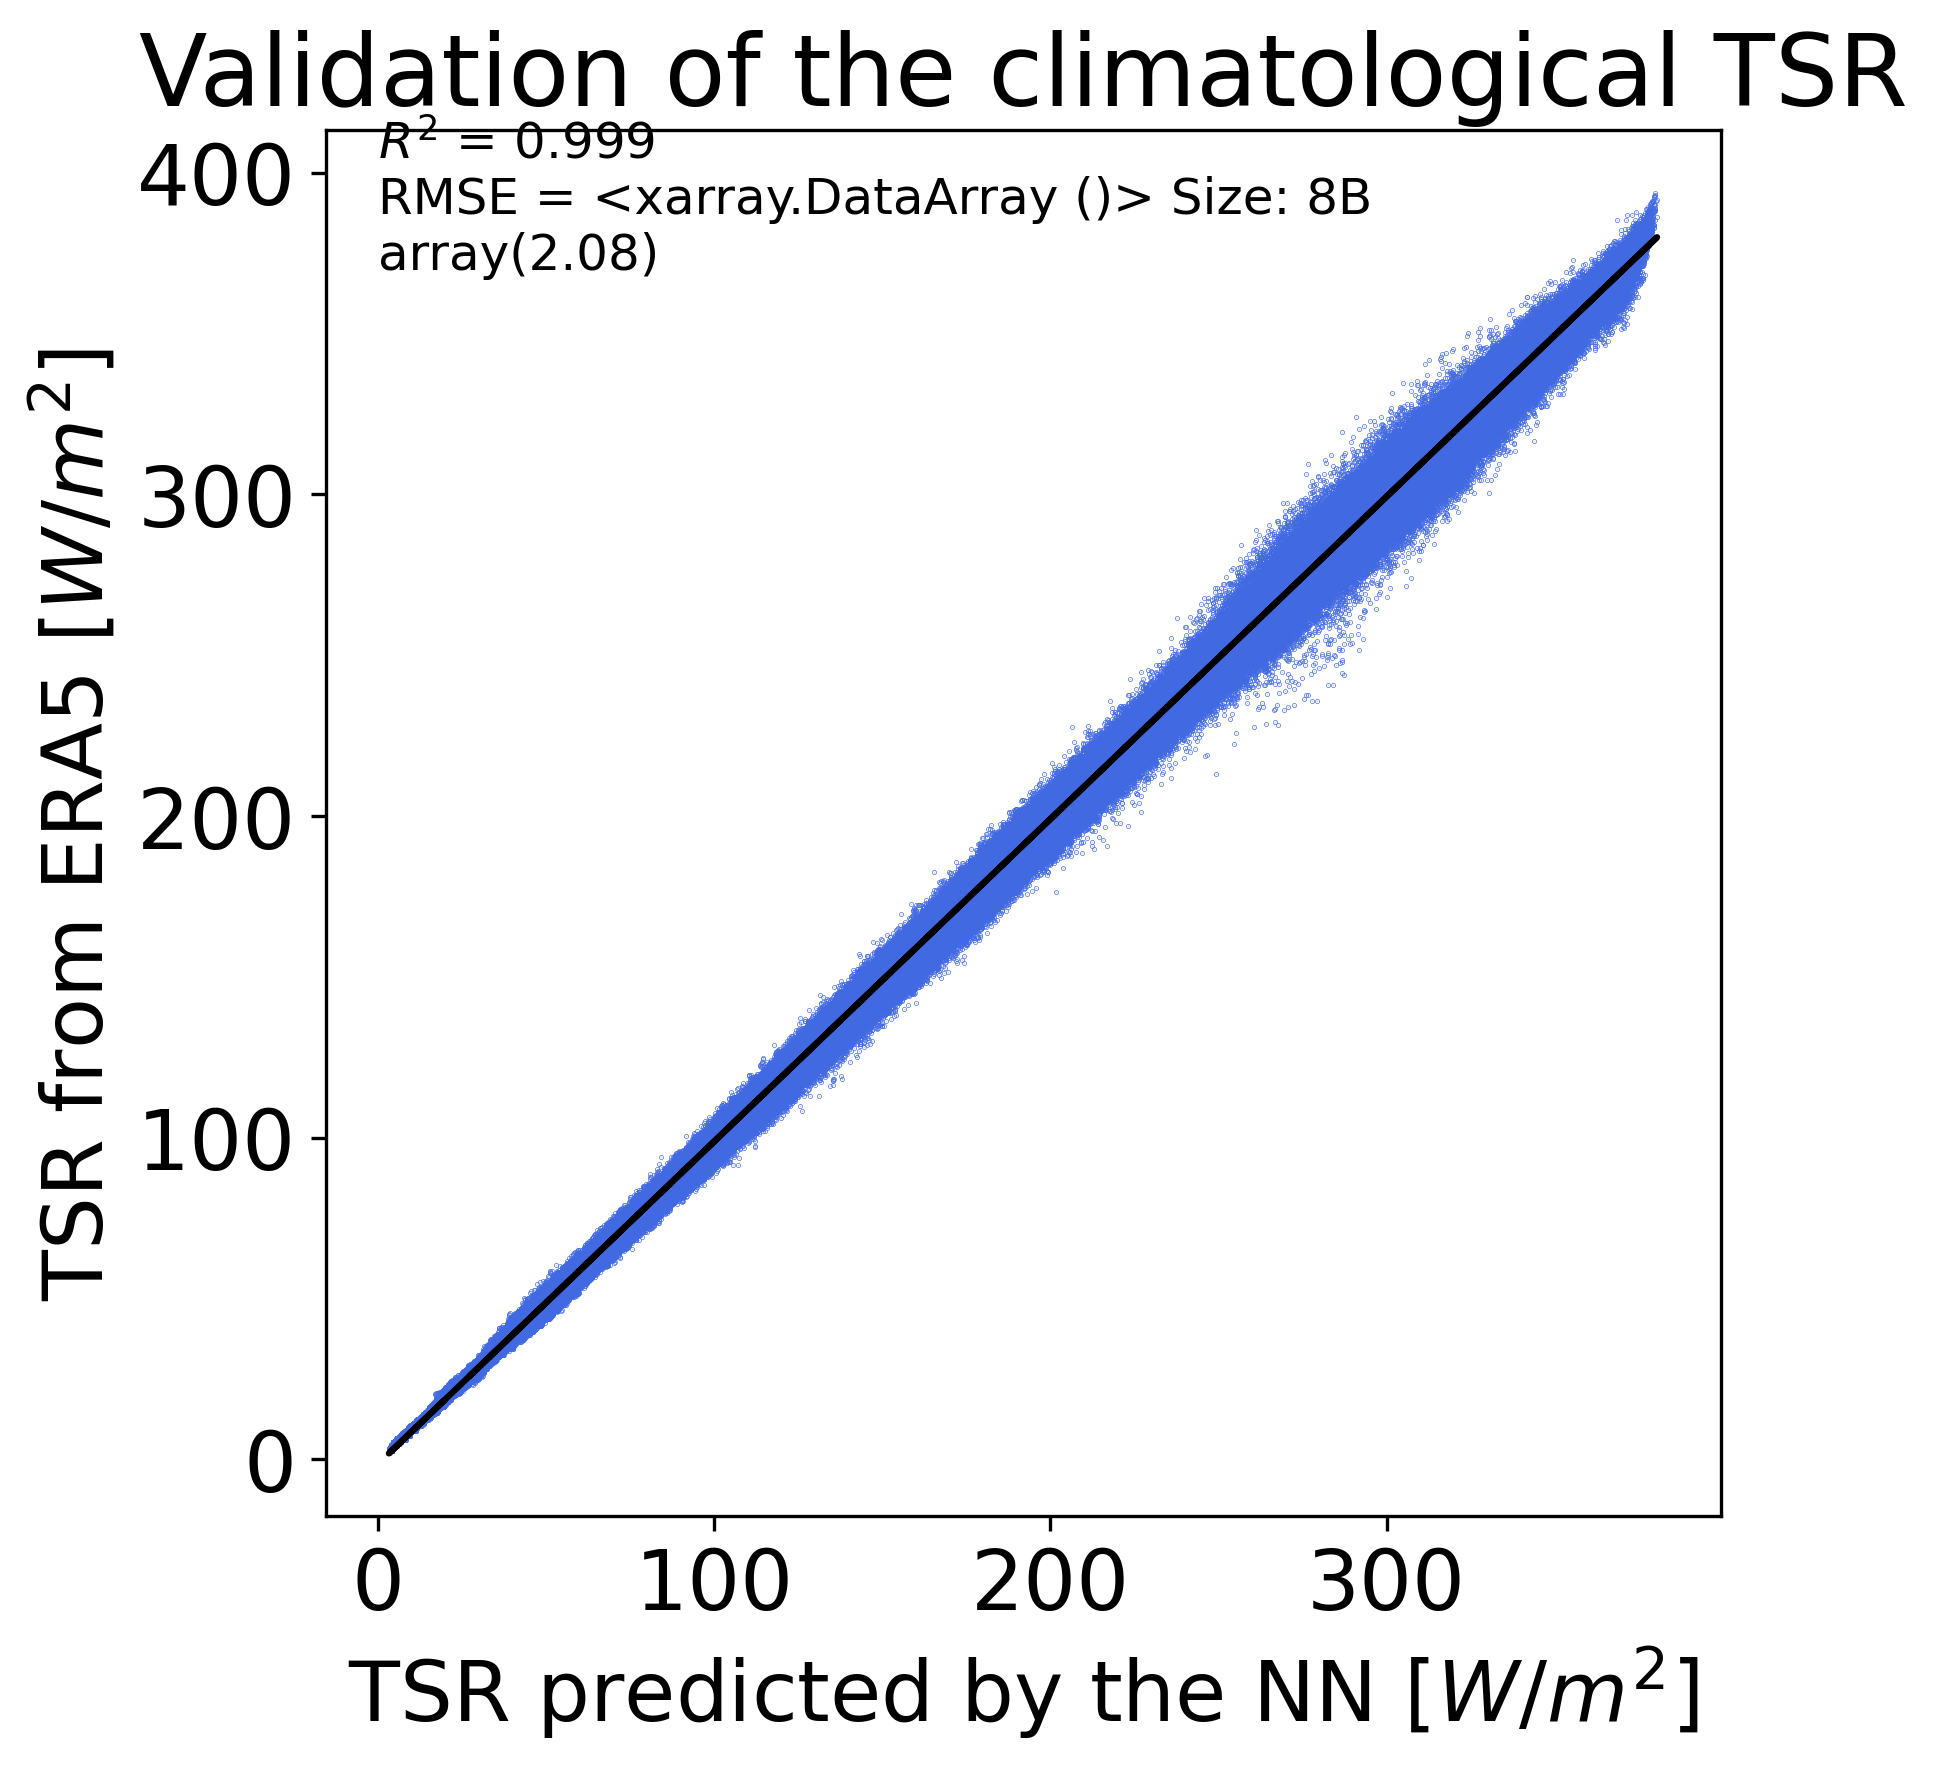

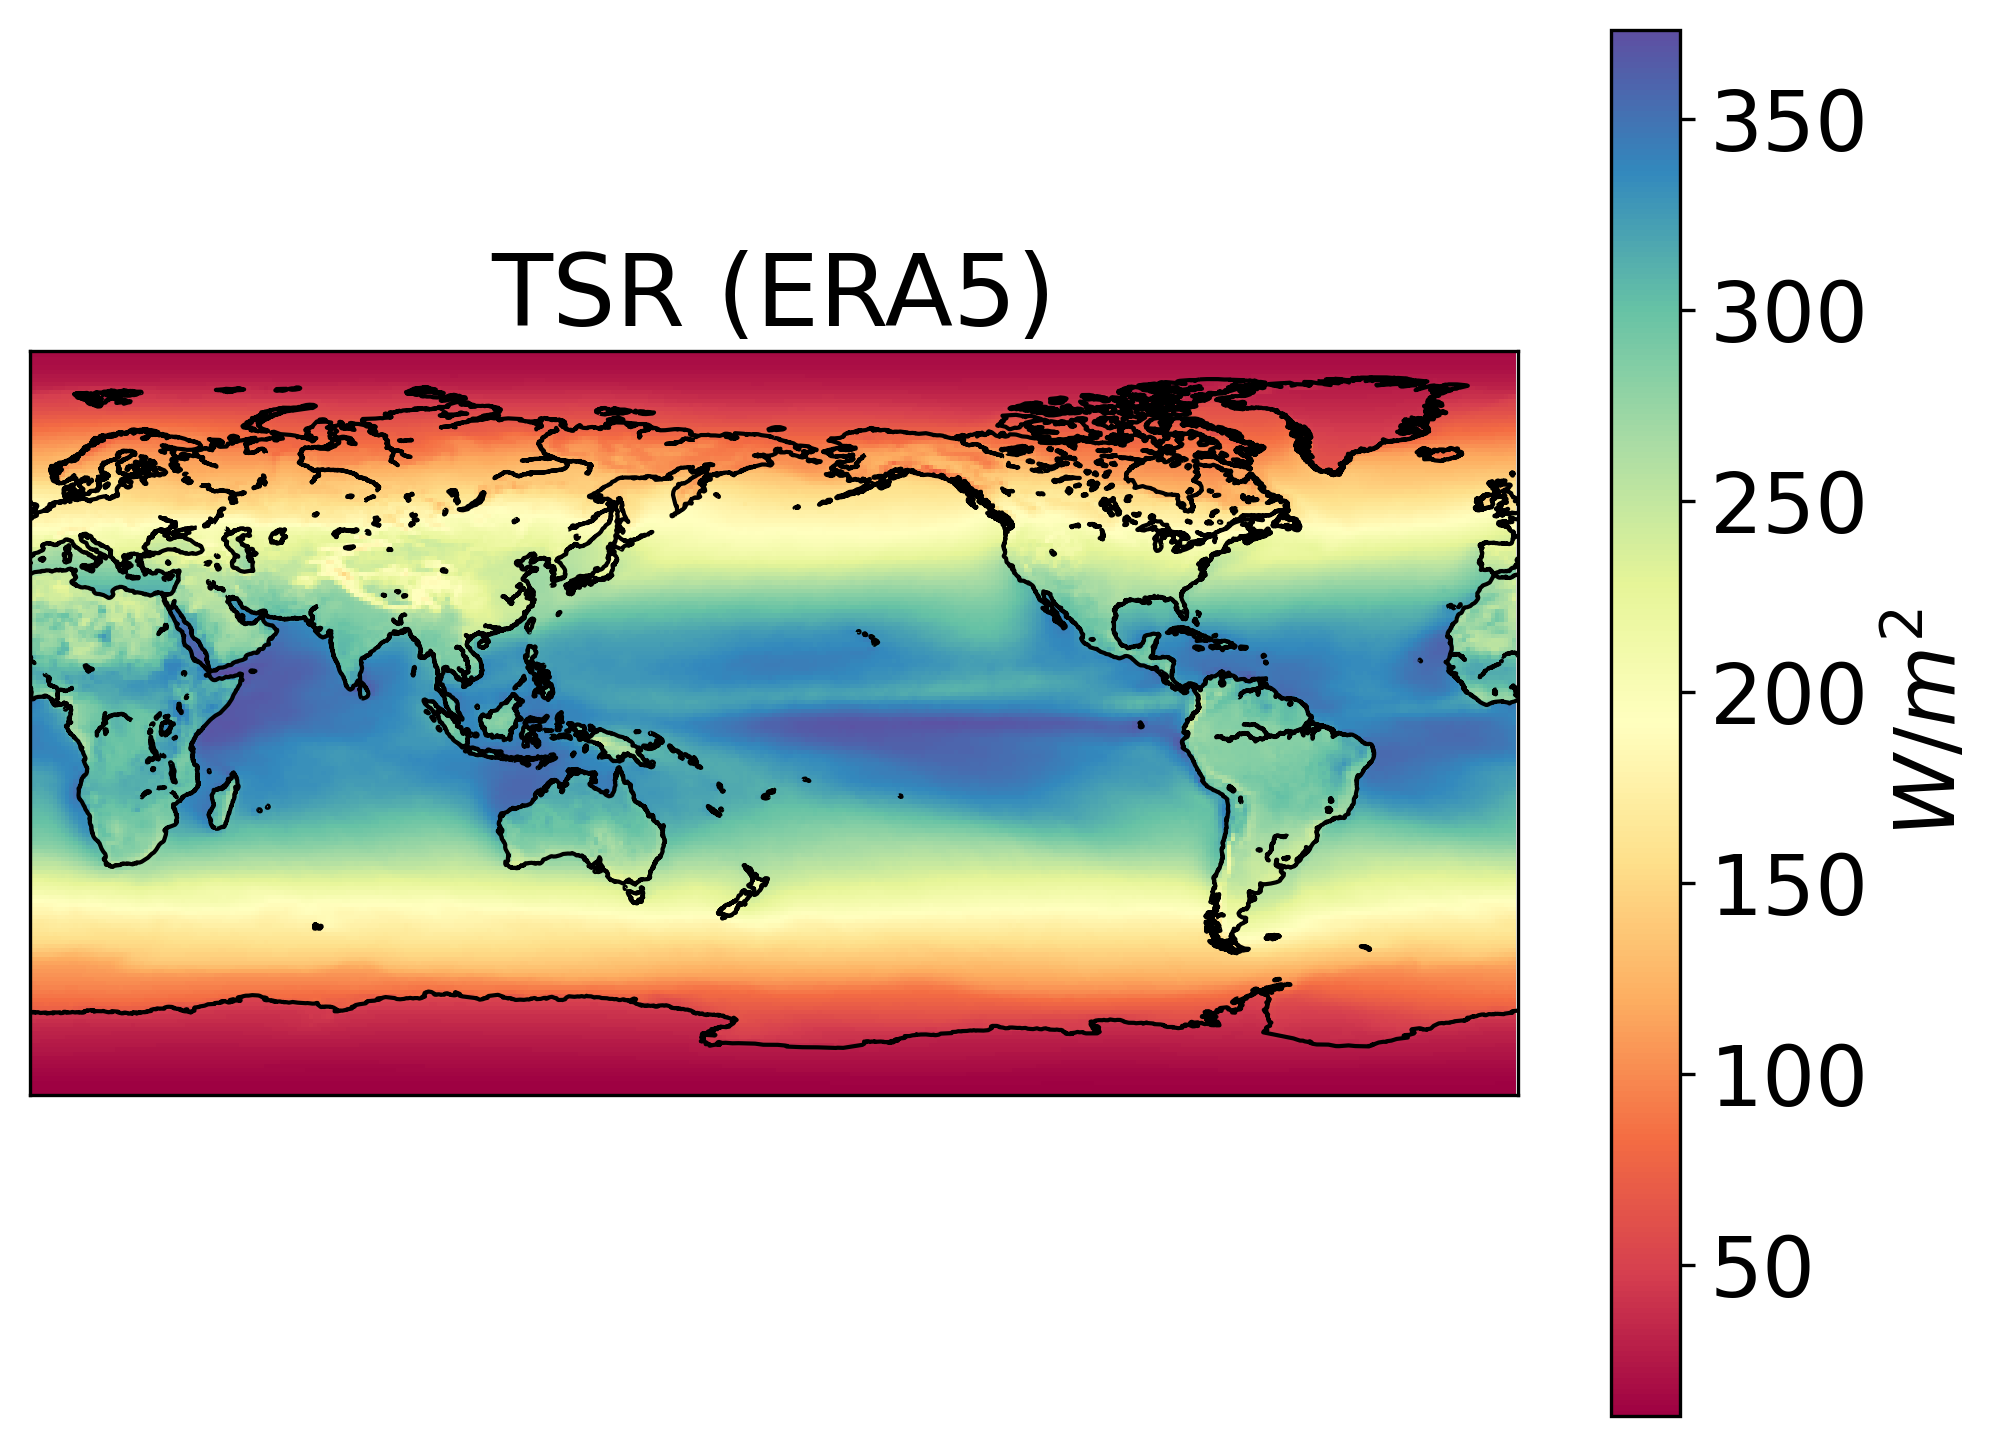

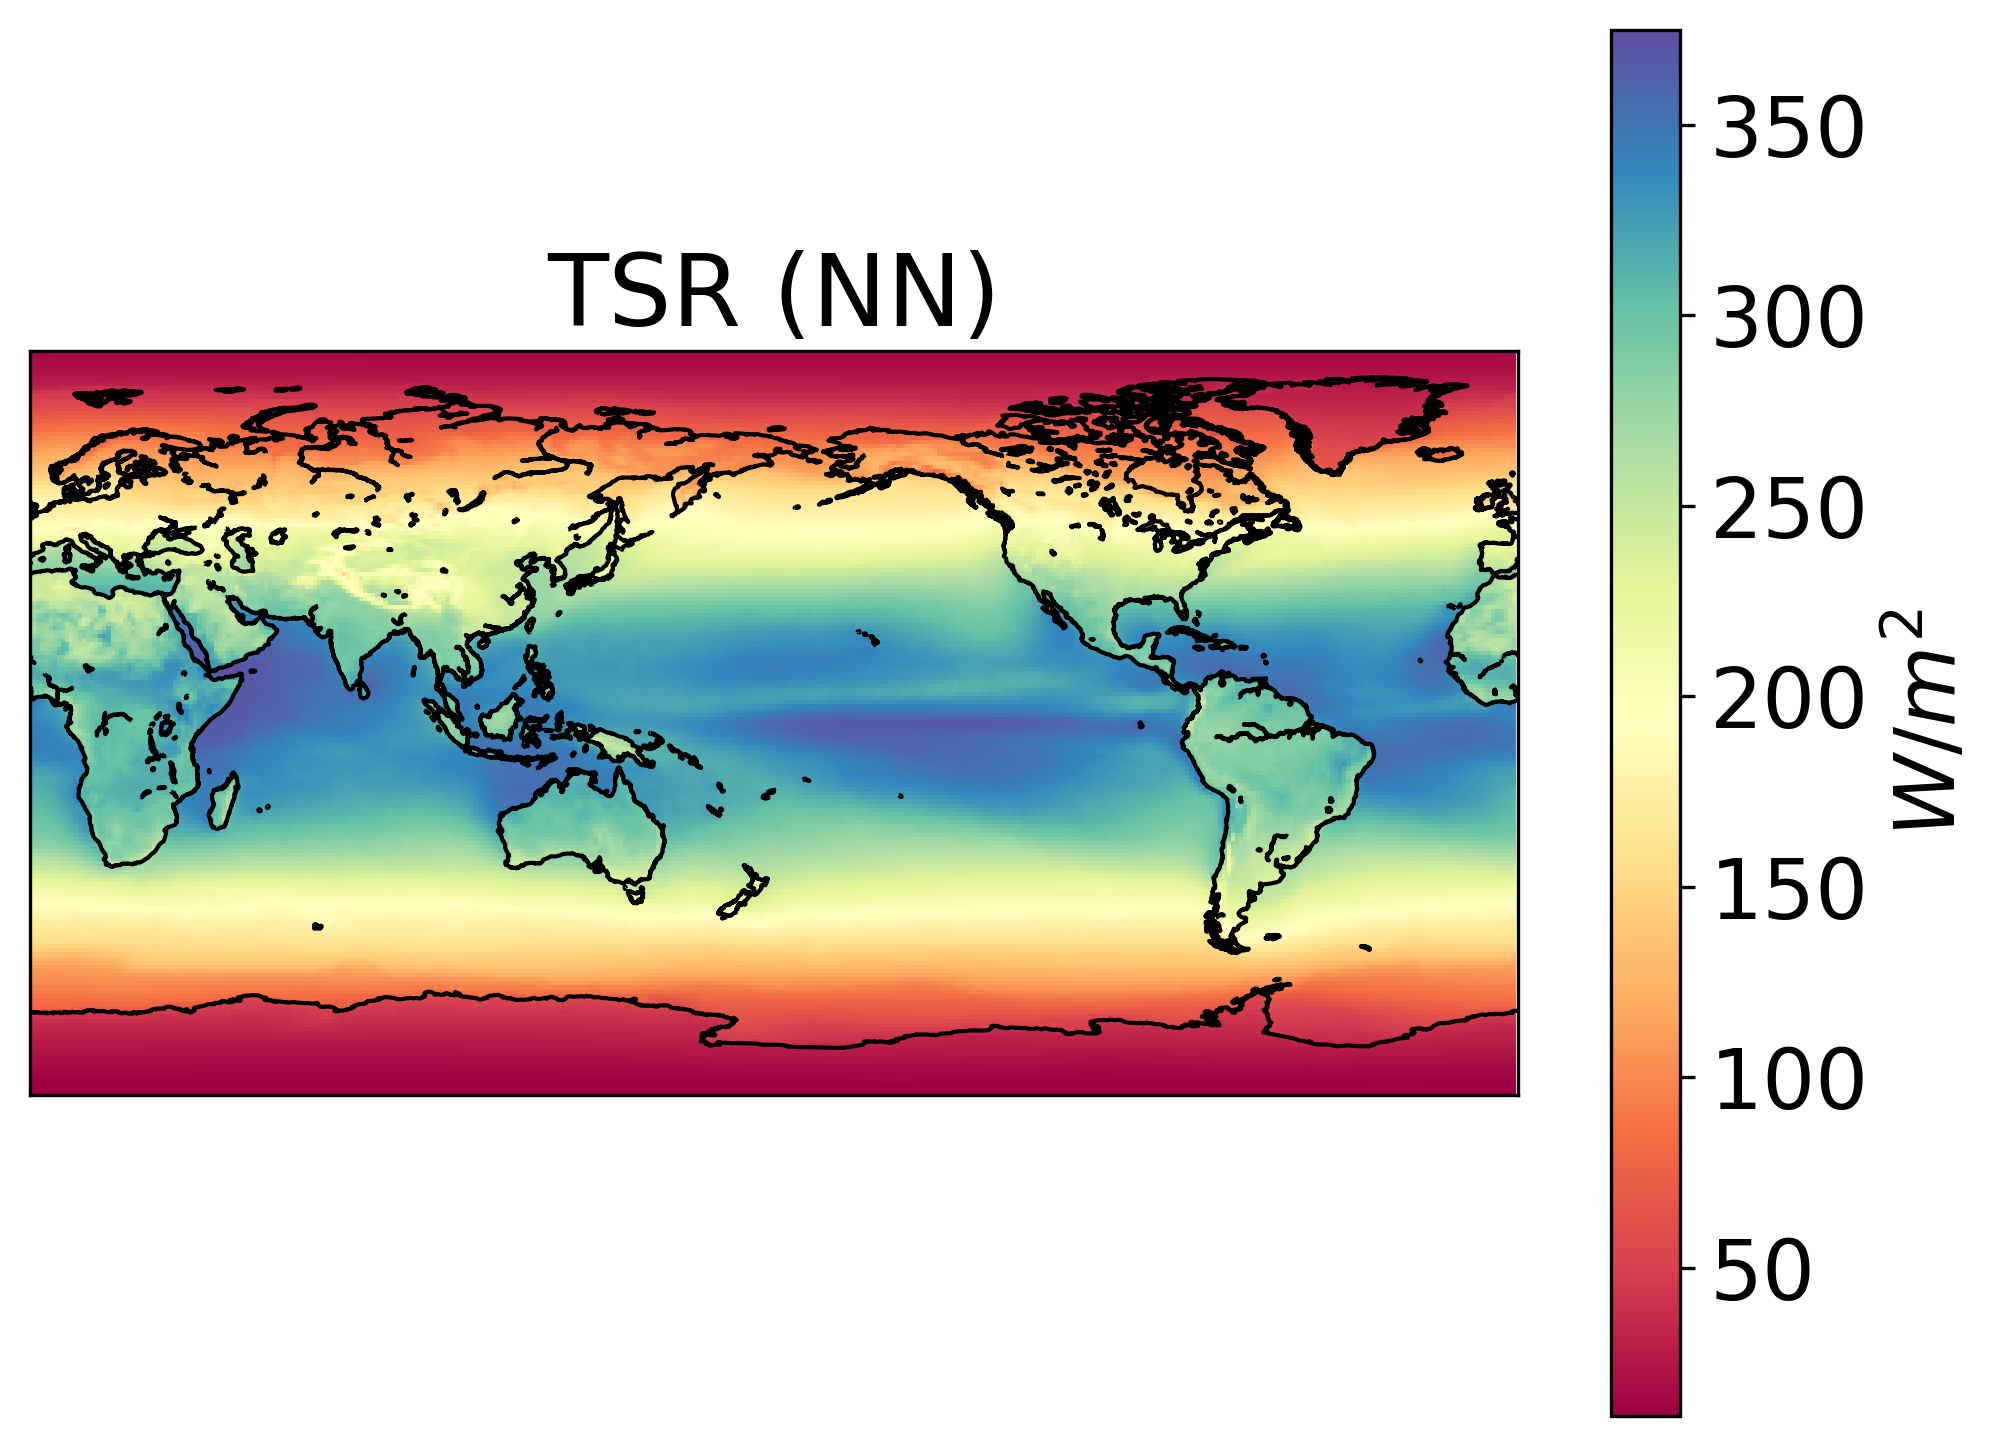

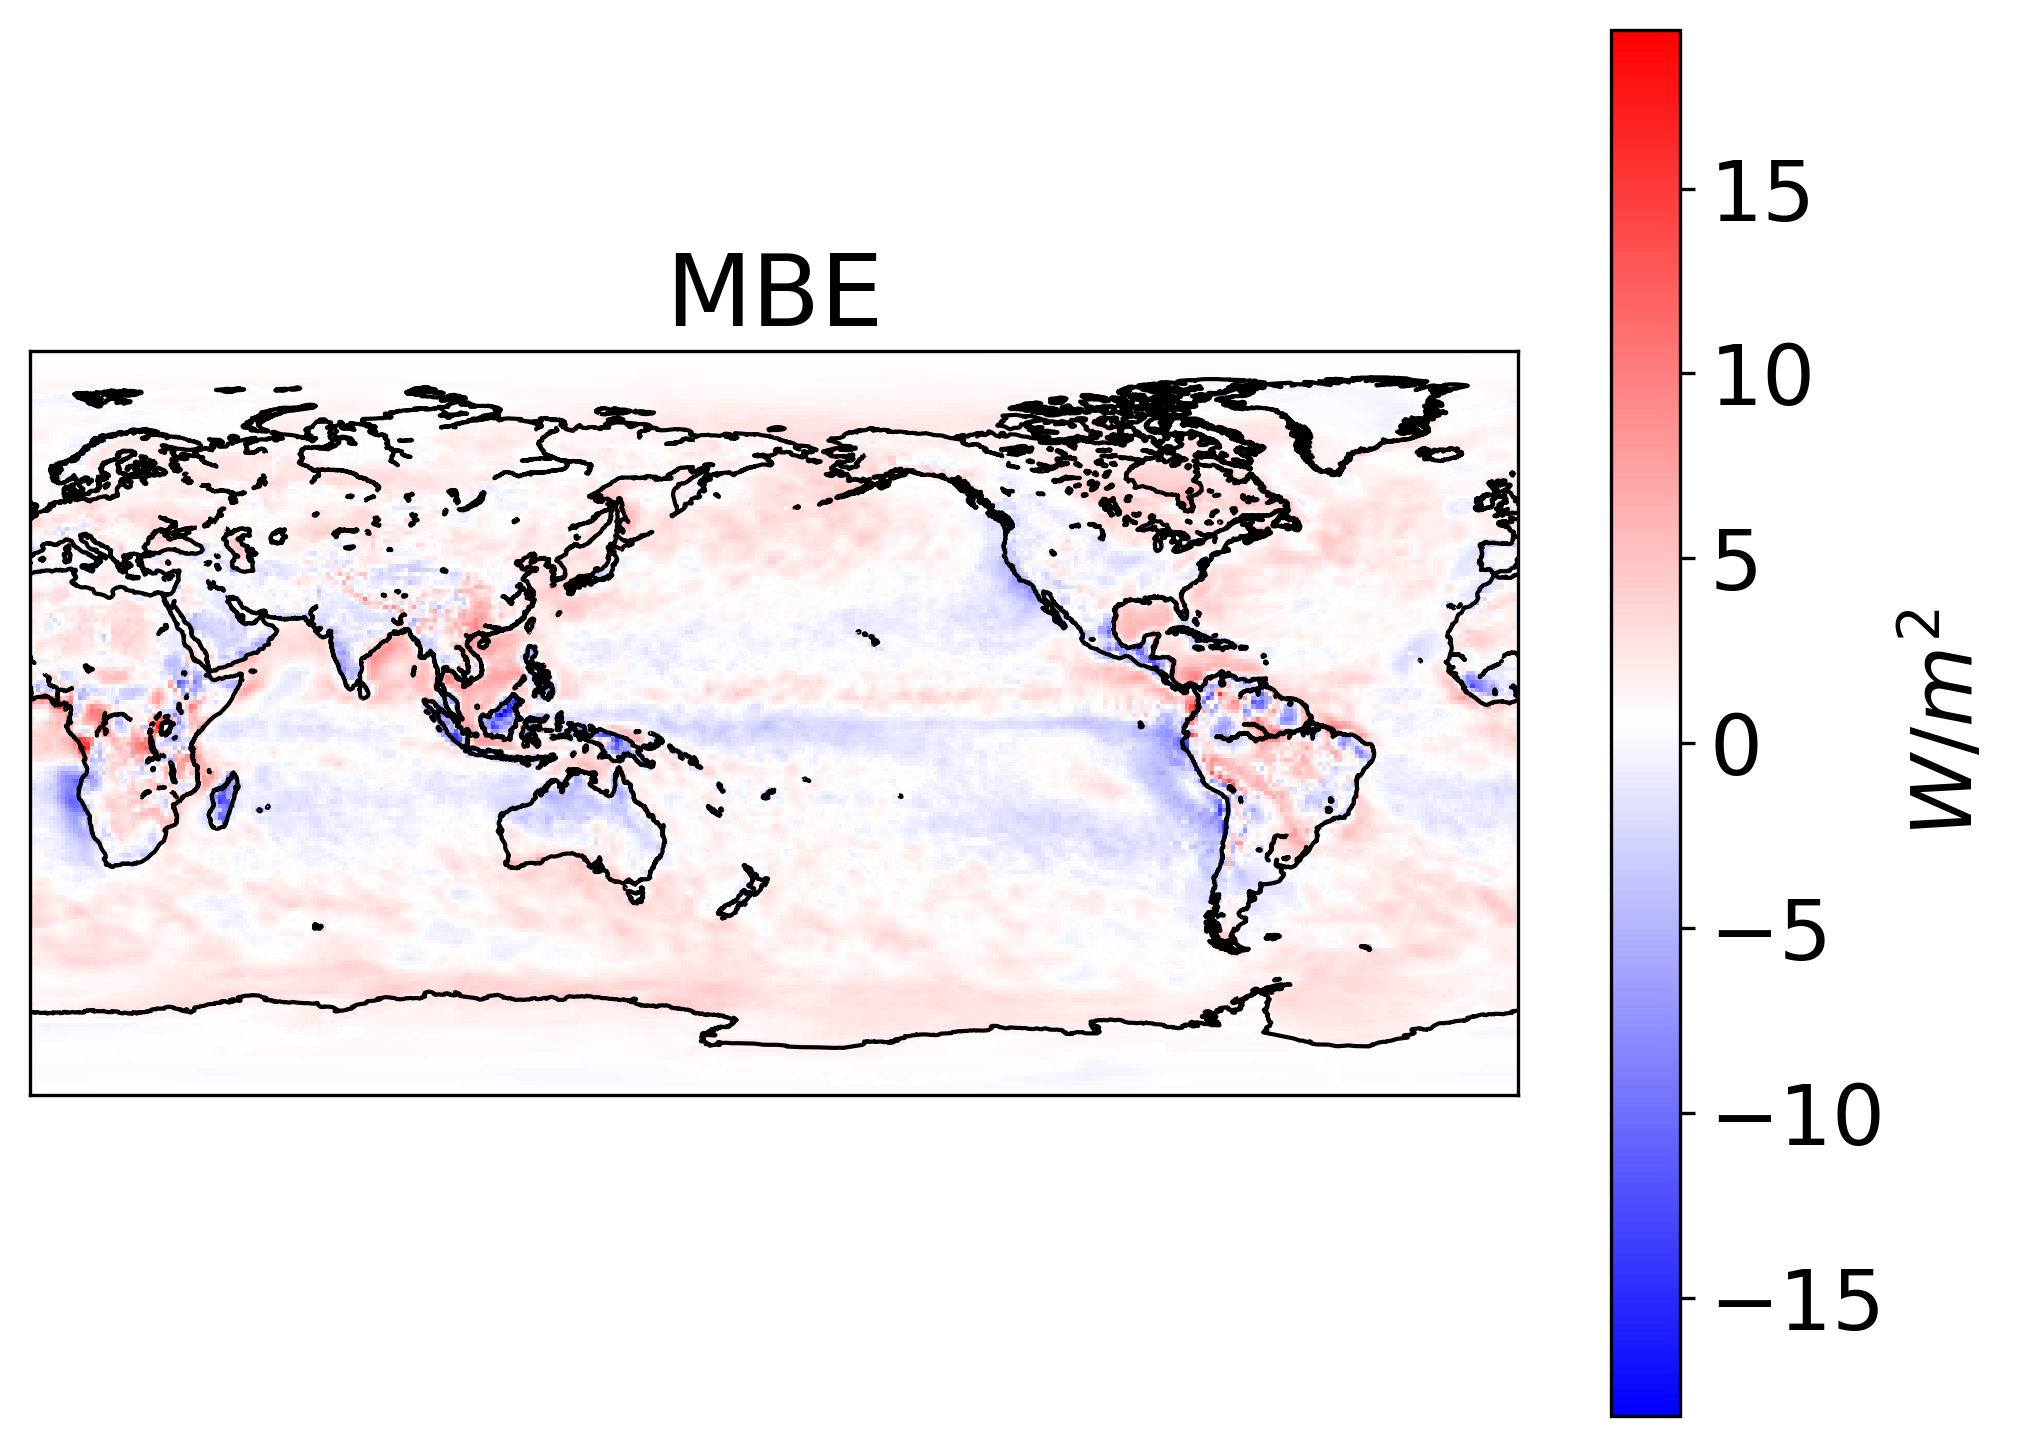

In [8]:


import os
import numpy as np
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap
from scipy.stats import linregress

# Set font size for plots
plt.rcParams['font.size'] = 20

# Data paths
DATA_PATH = "/content/data/Data for Quantification of Shortwave Surface Albedo Feedback using a Neural Network Approach/data/"
MODEL_SAVE_PATH = DATA_PATH + "nn_saved_model"

# Function for Min-Max Normalization
def MinMaxNorm(x, a, b):
    return a + (x - np.min(x)) * (b - a) / (np.max(x) - np.min(x))

# Function to Inverse Min-Max Normalization
def MinMaxInverse(norm_x, a, b, original_x):
    return (norm_x - a) * (np.max(original_x) - np.min(original_x)) / (b - a) + np.min(original_x)

# Load ERA5 dataset
file_sl = "era5_1deg_monthly_avg_sl_1990-2020_tisr_tciw_tclw_tcwv_hcc_mcc_lcc_sp_tco3_fal_tsr_msl_ecod_noZeros.nc"
xrr_sl = xr.open_dataset(DATA_PATH + file_sl)

# Convert accumulated values to W/m²
xrr_sl["tisr"] = xrr_sl.tisr / (24 * 3600)
xrr_sl["tsr"] = xrr_sl.tsr / (24 * 3600)

# Split dataset into even (training) and odd (testing) years
years = xrr_sl["time.year"]
xrr_sl_train = xrr_sl.sel(time=(years % 2 == 0))
xrr_sl_test = xrr_sl.sel(time=(years % 2 == 1))

# Convert to DataFrame
df_train = xrr_sl_train.to_dataframe()
df_test = xrr_sl_test.to_dataframe()

# Prepare input variables
vars_list_train = [
    np.array(df_train.tisr),
    np.array(df_train.tciw),
    np.array(df_train.tclw),
    np.array(df_train.tcwv),
    np.array(df_train.lcc),
    np.array(df_train.mcc),
    np.array(df_train.hcc),
    np.array(df_train.sp),
    np.array(df_train.tco3),
    np.array(df_train.fal),
    np.array(df_train.ecod),
    np.array(df_train.ecod * df_train.fal),
]
vars_list_test = [
    np.array(df_test.tisr),
    np.array(df_test.tciw),
    np.array(df_test.tclw),
    np.array(df_test.tcwv),
    np.array(df_test.lcc),
    np.array(df_test.mcc),
    np.array(df_test.hcc),
    np.array(df_test.sp),
    np.array(df_test.tco3),
    np.array(df_test.fal),
    np.array(df_test.ecod),
    np.array(df_test.ecod * df_test.fal),
]

# Normalize input and output
a, b = -1, 1
nrmlzd_vars_train = [MinMaxNorm(x, a, b) for x in vars_list_train]
nrmlzd_vars_test = [MinMaxNorm(x, a, b) for x in vars_list_test]

tsr_train = np.array(df_train.tsr)
tsr_test = np.array(df_test.tsr)

yy_train = MinMaxNorm(tsr_train, a, b)
yy_test = MinMaxNorm(tsr_test, a, b)

# Stack input features
xx_train = np.stack(nrmlzd_vars_train, axis=1)
xx_test = np.stack(nrmlzd_vars_test, axis=1)

# Define the Neural Network Model
model = keras.Sequential([
    layers.Dense(64, activation='tanh', input_shape=(xx_train.shape[1],)),
    layers.Dense(32, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1, activation='tanh')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(xx_train, yy_train, epochs=2, batch_size=32, validation_data=(xx_test, yy_test))

# Save the trained model
model.save(MODEL_SAVE_PATH)

# Load the trained model
model = keras.models.load_model(MODEL_SAVE_PATH)

# Make predictions
predictions = model.predict(xx_test)
predictions_rescaled = MinMaxInverse(predictions, a, b, df_test.tsr)

df_test['NN_predictions'] = predictions_rescaled
dataset = xr.Dataset.from_dataframe(df_test.squeeze())

# Calculate mean values
tsr_mean = dataset['tsr'].mean(dim='time').transpose()
NN_pred_mean = dataset['NN_predictions'].mean(dim='time').transpose()

# Compute metrics
MBE = np.round(np.mean(NN_pred_mean - tsr_mean), 2)
RMSE = np.round(np.sqrt(np.mean((NN_pred_mean - tsr_mean)**2)), 2)

# Scatter plot for validation
slope, intercept, r_value, _, _ = linregress(predictions_rescaled.squeeze(), tsr_test)
r_squared = np.round(r_value ** 2, 3)

plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(predictions_rescaled, tsr_test, color='royalblue', marker='.', s=0.1)
plt.plot(predictions_rescaled.squeeze(), predictions_rescaled.squeeze() * slope + intercept, color='k')
plt.xlabel('TSR predicted by the NN [$W/m^2$]')
plt.ylabel('TSR from ERA5 [$W/m^2$]')
plt.title('Validation of the climatological TSR')
plt.text(0, 370, f'$R^2$ = {r_squared}\nRMSE = {RMSE}', fontsize=12)
plt.savefig('validation.png')

# Save evaluation metrics
with open("metrics.txt", "w") as file:
    file.write(f"MBE = {MBE}\n")
    file.write(f"RMSE = {RMSE}\n")

# Plot TSR (ERA5)
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
m = Basemap(projection='cyl', resolution='l', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360)
lon, lat = np.meshgrid(dataset['lon'].values, dataset['lat'].values)
x, y = m(lon, lat)
m.pcolormesh(x, y, tsr_mean, shading='nearest', cmap='Spectral')
m.drawcoastlines()
plt.colorbar(label='$W/m^2$')
plt.title('TSR (ERA5)')
plt.savefig('tsr_test.png')

# Plot TSR (NN)
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
m.pcolormesh(x, y, NN_pred_mean, shading='nearest', cmap='Spectral')
m.drawcoastlines()
plt.colorbar(label='$W/m^2$')
plt.title('TSR (NN)')
plt.savefig('nn_predictions.png')

# Plot MBE
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
m.pcolormesh(x, y, NN_pred_mean - tsr_mean, shading='nearest', cmap='bwr')
m.drawcoastlines()
plt.colorbar(label='$W/m^2$')
plt.title('MBE')
plt.savefig('mbe.png')

print("Training and evaluation completed!")
